In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

from forecasting.preprocessing import (
    load_csv, build_month_start_date, normalize_sectors,
    transportation_from_biofuels, pivot_sector_timeseries,
    trim_period, maybe_log_transform, invert_log_transform
)

from forecasting.models import (
    seasonal_naive,
    forecast_rw_recursive,
    forecast_arima_recursive,
    forecast_sarima_recursive,
    forecast_var_recursive,
    forecast_varx_recursive,
)

from forecasting.evaluation import rmsfe
from pathlib import Path

In [2]:
CSV_PATH   = 'data/US_renewable_forecasting.csv'
MACRO_PATH = 'data/macro_vars.csv'

TEST_SIZE_RATIO = 0.2
VAR_LAGS = 4

VAR_SECTOR_COLS = [
    "Commercial",
    "Residential",
    "Transportation",
    "Industrial",
    "Electric Power",
]

def plot_stl(y: pd.Series, period=12, title=None):
    """STL decomposition per una singola serie."""
    res = STL(y, period=period).fit()
    fig = res.plot()
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
# === Renewable data ===
df = load_csv(CSV_PATH)
df = build_month_start_date(df)
df = normalize_sectors(df)
df = transportation_from_biofuels(df)

ts = pivot_sector_timeseries(df)
ts = trim_period(ts, start='1995-01-01')

ts.head()

Sector,Commercial,Electric Power,Industrial,Residential,Transportation
date,,,,,
1995-01-01,9.784,119.949,148.698,48.115,9.237
1995-02-01,8.713,114.390,123.271,44.051,8.420
1995-03-01,9.401,128.739,148.709,49.761,10.344
1995-04-01,10.126,123.899,168.353,48.832,9.554
1995-05-01,8.948,123.030,141.198,50.852,8.003


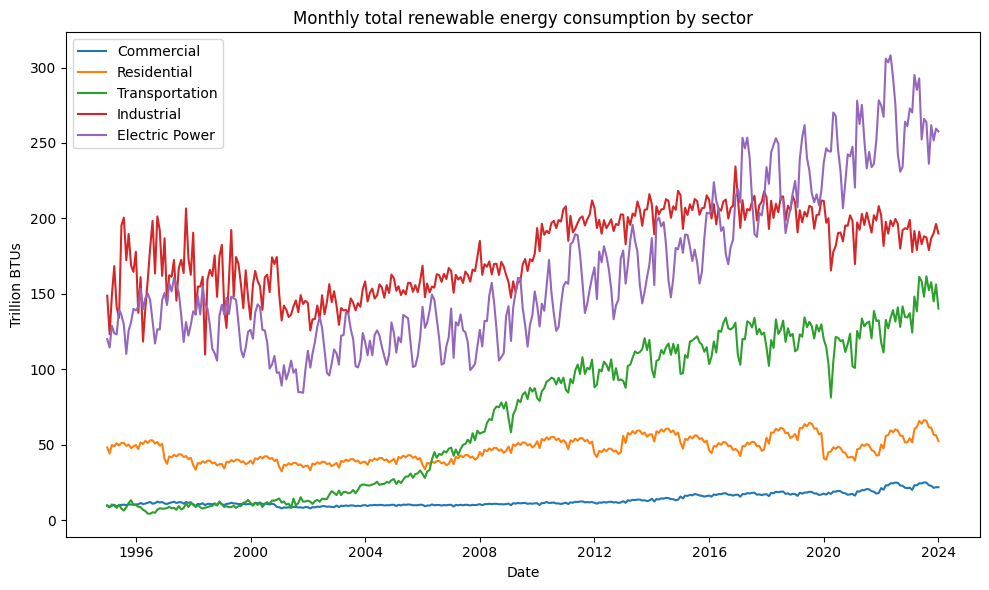

In [4]:
# === Descriptive plots ===
plt.figure(figsize=(10, 6))
for col in VAR_SECTOR_COLS:
    plt.plot(ts.index, ts[col], label=col)

plt.title("Monthly total renewable energy consumption by sector")
plt.xlabel("Date")
plt.ylabel("Trillion BTUs")
plt.legend()
plt.tight_layout()
plt.show()

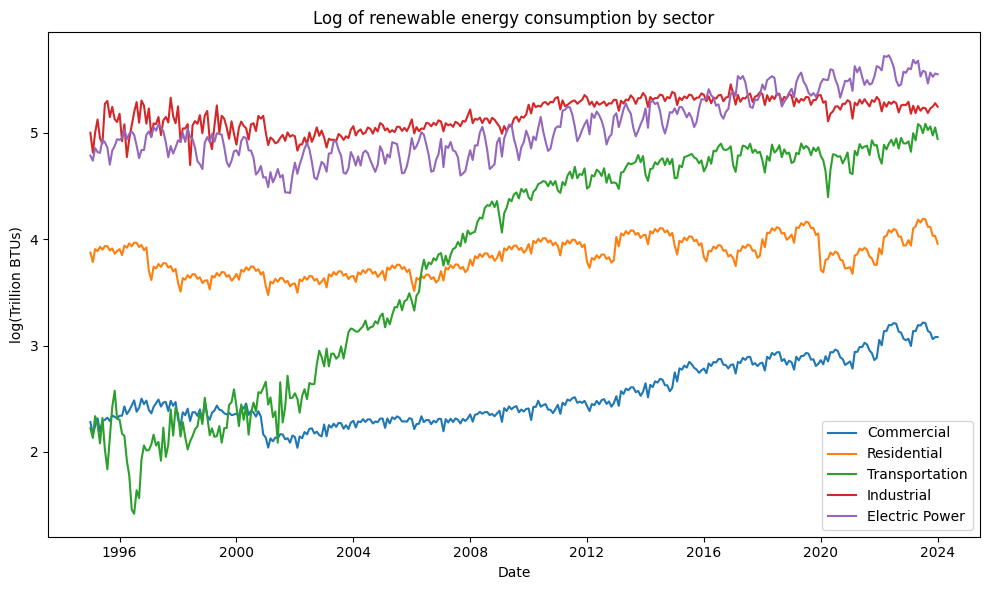

In [5]:
ts_log = np.log(ts)

plt.figure(figsize=(10, 6))
for col in VAR_SECTOR_COLS:
    plt.plot(ts_log.index, ts_log[col], label=col)

plt.title("Log of renewable energy consumption by sector")
plt.xlabel("Date")
plt.ylabel("log(Trillion BTUs)")
plt.legend()
plt.tight_layout()
plt.show()

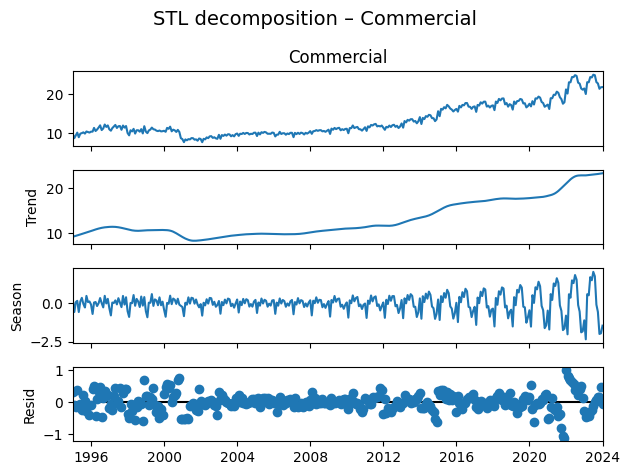

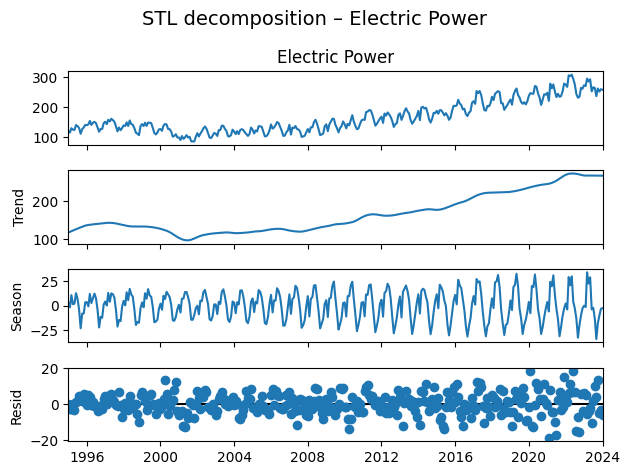

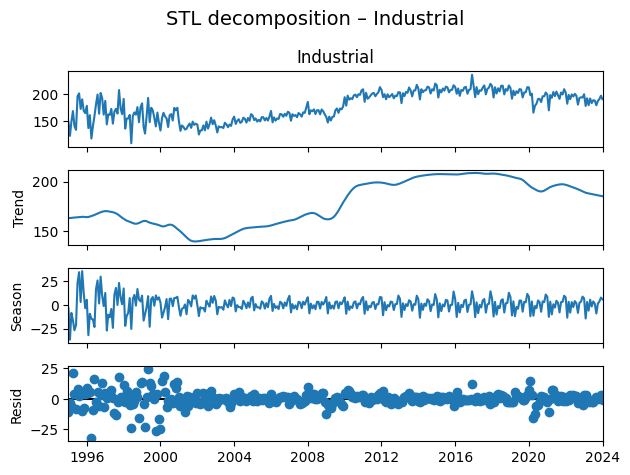

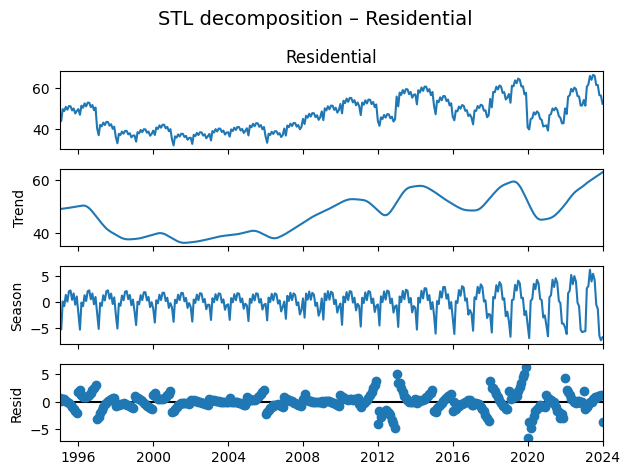

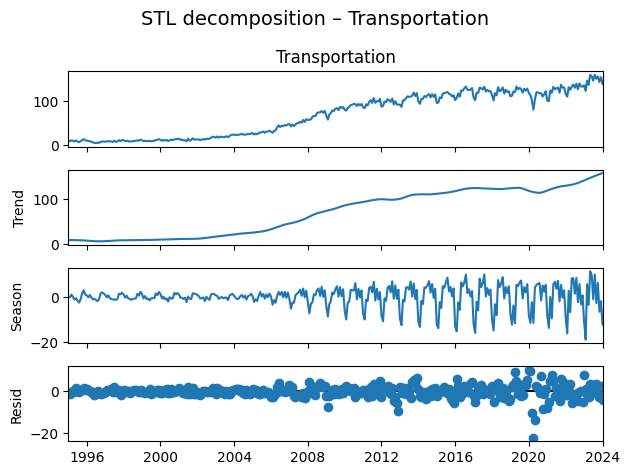

In [6]:
plot_stl(ts["Commercial"], period=12,
         title="STL decomposition – Commercial")

plot_stl(ts["Electric Power"], period=12,
         title="STL decomposition – Electric Power")

plot_stl(ts["Industrial"], period=12,
         title="STL decomposition – Industrial")

plot_stl(ts["Residential"], period=12,
         title="STL decomposition – Residential")

plot_stl(ts["Transportation"], period=12,
         title="STL decomposition – Transportation")

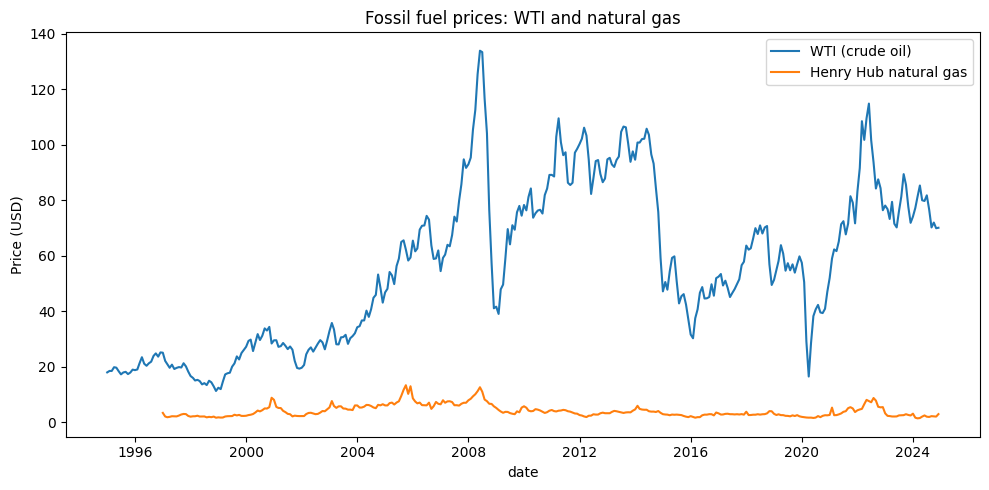

In [10]:
macro = pd.read_csv(MACRO_PATH, parse_dates=["date"])
macro.set_index("date", inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(macro.index, macro["WTI"], label="WTI (crude oil)")
plt.plot(macro.index, macro["gas"], label="Henry Hub natural gas")
plt.title("Fossil fuel prices: WTI and natural gas")
plt.xlabel("date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

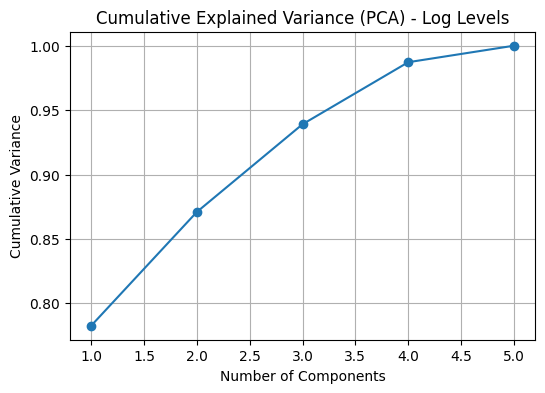

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sector_cols = ['Electric Power', 'Residential', 'Commercial',
               'Industrial', 'Transportation']

X = ts_log[sector_cols].dropna()

# Standardizzazione
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


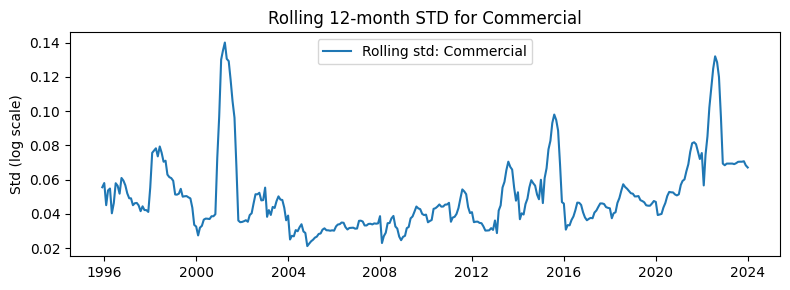

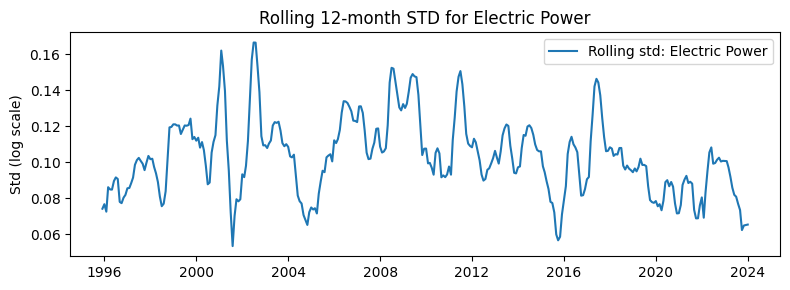

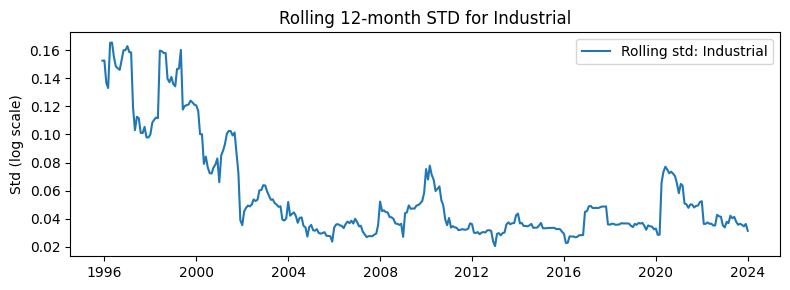

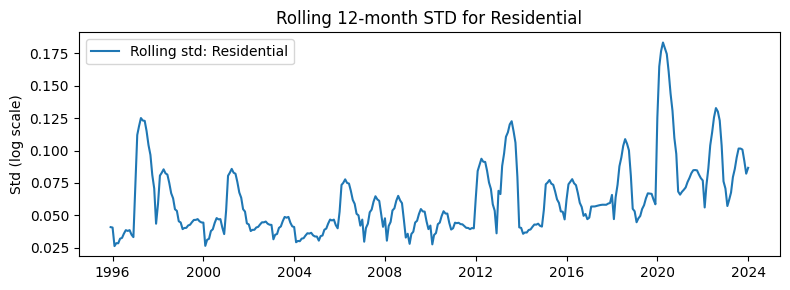

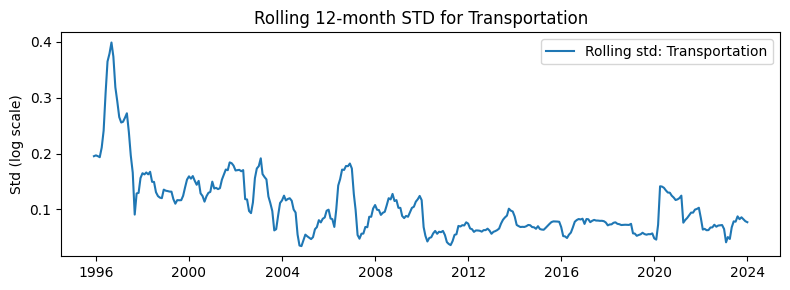

,Sector,JB_stat,JB_pvalue,Volatility_std_ratio
0,Commercial,31.963547,1.146051e-07,6.617870
1,Electric Power,17.937073,1.273544e-04,3.120972
2,Industrial,21.014849,2.733276e-05,8.022950
3,Residential,16.233348,2.985199e-04,6.985313
4,Transportation,42.035385,7.449586e-10,11.623219


In [9]:
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def volatility_and_normality_report(ts_log):
    results = []

    for col in ts_log.columns:
        y = ts_log[col].dropna()
        
        # === JB Normality Test ===
        jb_stat, jb_pvalue = jarque_bera(y)
        
        # === Rolling Std (Volatility) ===
        rolling_std = y.rolling(window=12).std()

        # Salva info
        results.append({
            'Sector': col,
            'JB_stat': jb_stat,
            'JB_pvalue': jb_pvalue,
            'Volatility_std_ratio': rolling_std.max() / rolling_std.min() if rolling_std.min() > 0 else np.nan
        })

        # === Plot volatilità ===
        plt.figure(figsize=(8, 3))
        plt.plot(rolling_std, label=f"Rolling std: {col}")
        plt.title(f"Rolling 12-month STD for {col}")
        plt.ylabel("Std (log scale)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

# Applica il log ai dati originali ts, se non già fatto
ts_log = np.log(ts)
report = volatility_and_normality_report(ts_log)
display(report)

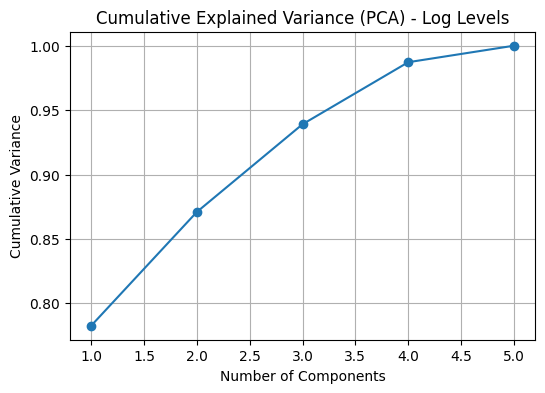

In [10]:
# PCA
pca = PCA()
pca.fit(X_std)

# Varianza spiegata
explained = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained.cumsum(), marker='o')
plt.title("Cumulative Explained Variance (PCA) - Log Levels")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()

Common-Factor Structure (PCA Analysis)

To explore the cross-sectional structure of renewable energy production, we perform a Principal Component Analysis (PCA) on the log levels of the five sectoral series (Electric Power, Residential, Commercial, Industrial, Transportation).

The first principal component (PC1) explains approximately 78% of the total variance, while the first two components jointly explain about 87%. This indicates the presence of a strong common factor driving most of the co-movement across sectors.

The dominance of the first component suggests that renewable energy sectors tend to move together over time, consistent with the idea of a common long-run trend.

This finding provides empirical support for adopting multivariate forecasting models such as VAR and VARX, which are specifically designed to capture shared dynamics among related time series

In [11]:
import pandas as pd

# Loadings della prima componente
pc1_loadings = pd.DataFrame(
    pca.components_[0],     # prima componente
    index=sector_cols,
    columns=['PC1_loading']
)

display(pc1_loadings)

,PC1_loading
Electric Power,0.460438
Residential,0.427814
Commercial,0.467611
Industrial,0.443178
Transportation,0.435781


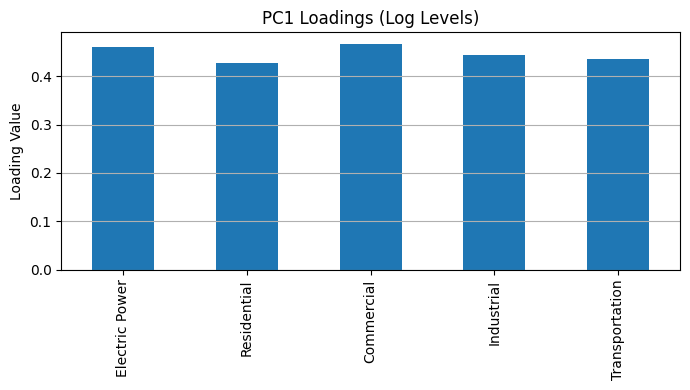

In [27]:
plt.figure(figsize=(7,4))
pc1_loadings['PC1_loading'].plot(kind='bar')
plt.title("PC1 Loadings (Log Levels)")
plt.ylabel("Loading Value")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

PCA loadings on the first principal component are all positive and very similar in magnitude (around 0.45), indicating that PC1 is essentially a broad common factor affecting all renewable energy sectors.
This suggests that most of the variability is driven by a common component, while sector-specific dynamics remain in the residual variance.
For this reason, we forecast each sector separately but within a multivariate framework (VAR/VARX), which naturally exploits the strong co-movement while still allowing for heterogeneous responses across sectors and to macroeconomic regressors.

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=36, title_prefix=""):
    """Return ACF/PACF figure without closing it."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(series, lags=lags, ax=axes[0])
    plot_pacf(series, lags=lags, ax=axes[1], method="ywm")

    axes[0].set_title(f"{title_prefix} – ACF")
    axes[1].set_title(f"{title_prefix} – PACF")

    plt.tight_layout()
    return fig

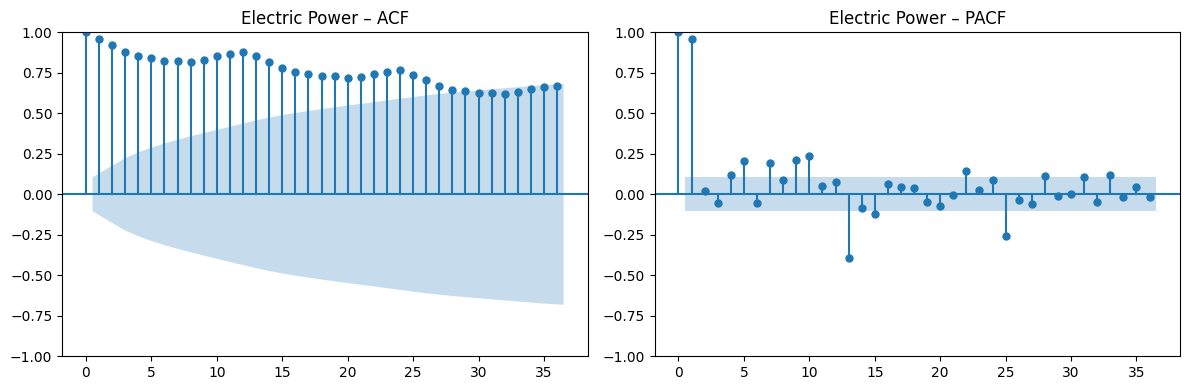

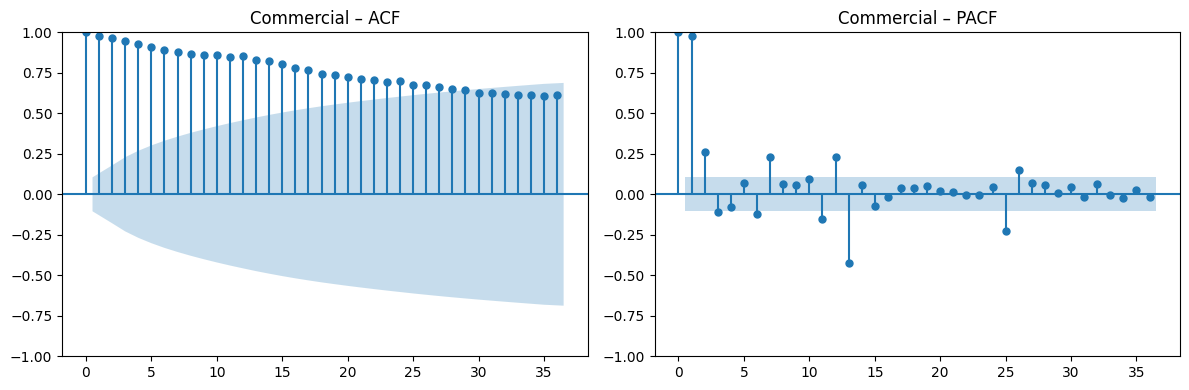

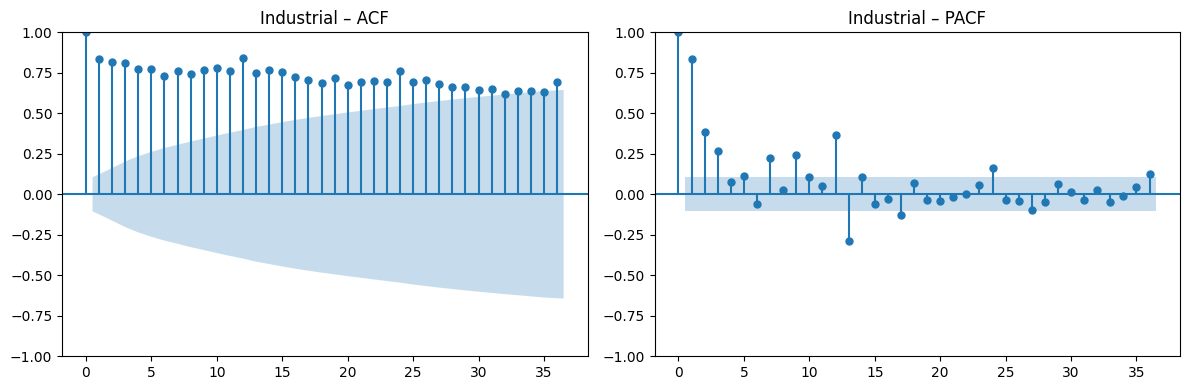

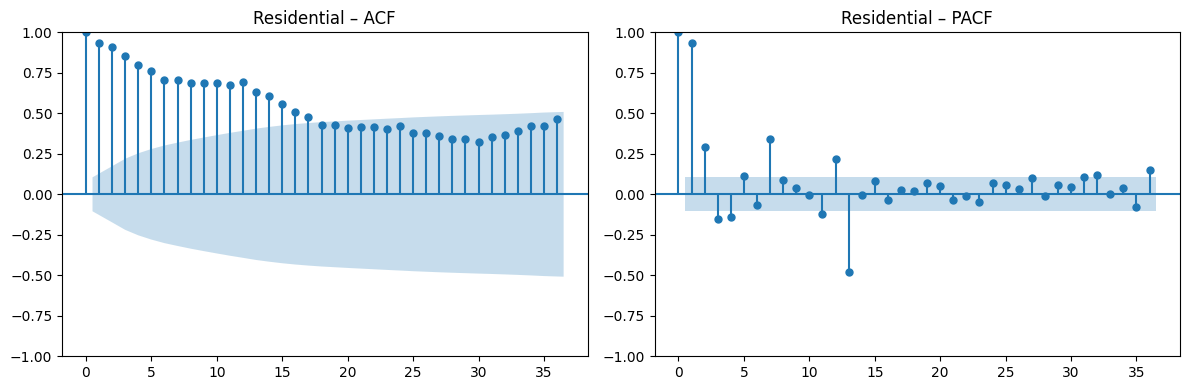

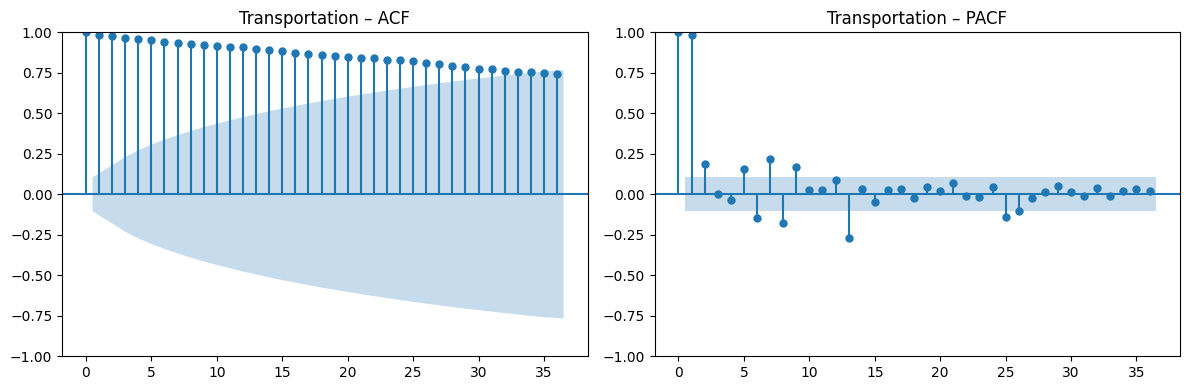

In [11]:
out_dir = Path("outputs/plots/ACF_PACF")
out_dir.mkdir(parents=True, exist_ok=True)

fig = plot_acf_pacf(ts["Electric Power"], lags=36, title_prefix="Electric Power")
fig.savefig(out_dir / "ElectricPower.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Commercial"], lags=36, title_prefix="Commercial")
fig.savefig(out_dir / "Commercial.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Industrial"], lags=36, title_prefix="Industrial")
fig.savefig(out_dir / "Industrial.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Residential"], lags=36, title_prefix="Residential")
fig.savefig(out_dir / "Residential.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Transportation"], lags=36, title_prefix="Transportation")
fig.savefig(out_dir / "Transportation.png", dpi=300)
plt.show()

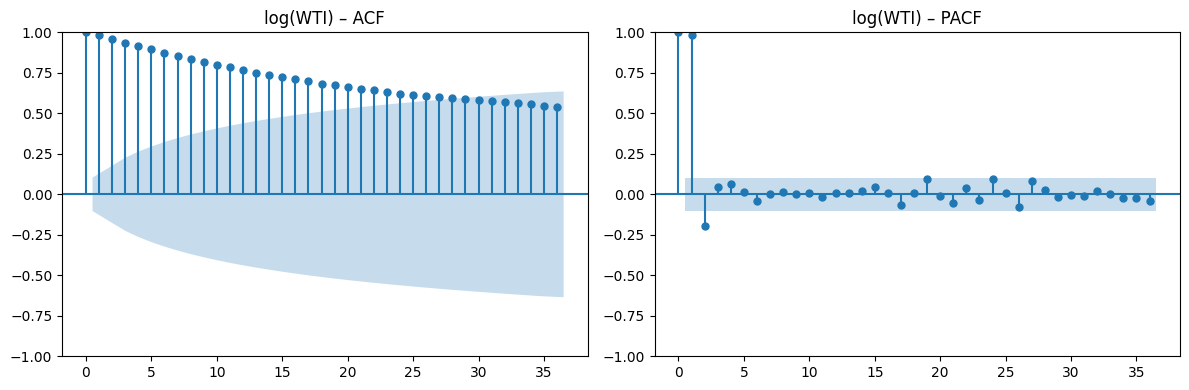

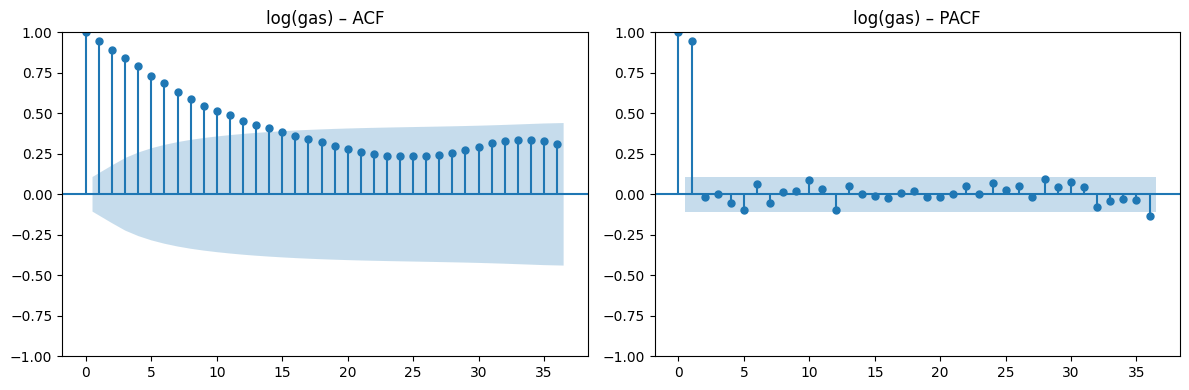

In [12]:
out_dir = Path("outputs/plots/ACF_PACF")
out_dir.mkdir(parents=True, exist_ok=True)

macro_log = pd.DataFrame({
    "log_WTI": np.log(macro["WTI"]),
    "log_gas": np.log(macro["gas"])
})

# WTI
fig = plot_acf_pacf(macro_log["log_WTI"].dropna(), lags=36, title_prefix="log(WTI)")
fig.savefig(out_dir / "WTI.png", dpi=300)
plt.show()

# Gas
fig = plot_acf_pacf(macro_log["log_gas"].dropna(), lags=36, title_prefix="log(gas)")
fig.savefig(out_dir / "gas.png", dpi=300)
plt.show()


The ACF and PACF plots confirm strong persistence and seasonal structure in several sectors (notably Residential and Electric Power), consistent with the presence of long-run growth and yearly cycles. Transportation shows negligible seasonality after the biofuel adjustment. The volatility of WTI and natural gas prices is reflected in jagged ACF/PACF patterns, indicating weak predictability and helping explain the poor performance of the VAR-X model.

In [ ]:
## DON'T NEED IT ANYMORE

out_dir = Path("outputs/plots/RMSFE")
out_dir.mkdir(parents=True, exist_ok=True)

# Carica i risultati dei modelli
fs   = pd.read_csv("outputs/forecast_summary.csv").set_index("Series")
var  = pd.read_csv("outputs/forecast_summary_var.csv").set_index("Series")
varx = pd.read_csv("outputs/forecast_summary_varx.csv").set_index("Series")

metrics = pd.DataFrame({
    "RMSFE_sNaive": fs["RMSFE_sNaive"],
    "RMSFE_RW":     fs["RMSFE_RW"],
    "RMSFE_ARIMA":  fs["RMSFE_ARIMA"],
    "RMSFE_SARIMA": fs["RMSFE_SARIMA"],
    "RMSFE_VAR":    var["RMSFE_VAR"],
    "RMSFE_VARX":   varx["RMSFE_VARX"],
})

metrics.to_csv(out_dir / "RMSFE_comparison_table.csv", float_format="%.4f")

metrics

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/forecast_summary_var.csv'

In [13]:
out_dir = Path("outputs/plots/RMSFE")
out_dir.mkdir(parents=True, exist_ok=True)

for sector in metrics.index:
    plt.figure(figsize=(8, 4))
    metrics.loc[sector].plot(kind="bar")
    plt.title(f"RMSFE comparison – {sector}")
    plt.ylabel("RMSFE")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_dir / f"rmsfe_{sector.replace(' ', '_')}.png", dpi=300)
    plt.show()

NameError: name 'metrics' is not defined

In [14]:
def plot_actual_vs_bench(ts: pd.DataFrame, sector: str):
    """
    Per ogni settore, identifica il benchmark con RMSFE più basso
    tra sNaive, RW, ARIMA, SARIMA, ricomputa le previsioni e plotta
    actual vs forecast sul test set.
    """
    # choose best model
    row = fs.loc[sector]
    rmsfe_map = {
        "sNaive": "RMSFE_sNaive",
        "RW":     "RMSFE_RW",
        "ARIMA":  "RMSFE_ARIMA",
        "SARIMA": "RMSFE_SARIMA",
    }
    best_name = min(rmsfe_map, key=lambda k: row[rmsfe_map[k]])
    best_rmsfe = row[rmsfe_map[best_name]]
    
    # sector in levels and log-transformation
    y_raw = ts[sector].dropna()
    y_t, logged = maybe_log_transform(y_raw)
    
    # split train/test
    h = max(1, int(round(len(y_t) * TEST_SIZE_RATIO)))
    test_index = y_t.index[-h:]
    
    # log previsions for each benchmark
    ARIMA_ORDER_GRID = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1)]

    yhat_s = seasonal_naive(y_t).loc[test_index]
    yhat_rw = forecast_rw_recursive(y_t).loc[test_index]
    yhat_ar, _ = forecast_arima_recursive(y_t, ARIMA_ORDER_GRID)
    yhat_ar = yhat_ar.loc[test_index]
    yhat_sar, _, _ = forecast_sarima_recursive(y_t)
    yhat_sar = yhat_sar.loc[test_index]

    preds_log = {
        "sNaive": yhat_s,
        "RW":     yhat_rw,
        "ARIMA":  yhat_ar,
        "SARIMA": yhat_sar,
    }

    yhat_best_log = preds_log[best_name]
    
    # back to levels for the plot
    y_test = y_raw.loc[test_index]
    if logged:
        yhat_best = invert_log_transform(yhat_best_log, True)
    else:
        yhat_best = yhat_best_log
    
    # plot
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(y_test.index, y_test.values, label="Actual")
    ax.plot(yhat_best.index, yhat_best.values,
            label=f"{best_name} forecast")

    ax.set_title(f"{sector} – best benchmark: {best_name} (RMSFE={best_rmsfe:.2f})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trillion BTUs")
    ax.legend()
    fig.tight_layout()

    return fig  

In [ ]:
out_dir = Path("outputs/plots/actual_vs_best_benchmark")
out_dir.mkdir(parents=True, exist_ok=True)

for sector in VAR_SECTOR_COLS:
    fig = plot_actual_vs_bench(ts, sector)
    fname = sector.replace(" ", "_") + "_best_benchmark.png"
    fig.savefig(out_dir / fname, dpi=300)
    plt.show()

In [ ]:
def plot_actual_vs_var(ts: pd.DataFrame, sector: str):
    """Stima un VAR e restituisce la figura actual vs forecast (test) per un settore."""
    y_test, y_hat = forecast_var_recursive(
        ts=ts,
        target_col=sector,
        var_cols=VAR_SECTOR_COLS,
        test_size_ratio=TEST_SIZE_RATIO,
        maxlags=VAR_LAGS,
    )

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(y_test.index, y_test.values, label="Actual")
    ax.plot(y_test.index, y_hat.values, label="VAR forecast")

    ax.set_title(f"{sector} – actual vs VAR forecast (test sample)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trillion BTUs")
    ax.legend()
    fig.tight_layout()

    print(f"RMSFE_VAR ({sector}): {rmsfe(y_test, y_hat):.3f}")

    return fig

In [ ]:
out_dir = Path("outputs/plots/actual_vs_VAR")
out_dir.mkdir(parents=True, exist_ok=True)

fig = plot_actual_vs_var(ts, "Electric Power")
fig.savefig(out_dir / "ElectricPower_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Transportation")
fig.savefig(out_dir / "Transportation_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Residential")
fig.savefig(out_dir / "Residential_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Commercial")
fig.savefig(out_dir / "Commercial_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Industrial")
fig.savefig(out_dir / "Industrial_var.png", dpi=300)
plt.show()

In [15]:
from forecasting.models import forecast_varx_recursive
macro = pd.read_csv(MACRO_PATH, parse_dates=["date"]); macro.set_index("date", inplace=True)

# log-prices
macro_log = pd.DataFrame({
    "log_WTI": np.log(macro["WTI"]),
    "log_gas": np.log(macro["gas"])
})

exog = macro_log[["log_WTI", "log_gas"]]

# ≈ 1997+
mask = exog.notna().all(axis=1)
ts_vx = ts.loc[mask]
exog_vx = exog.loc[mask]

ts_vx.head(), exog_vx.head()

(Sector      Commercial  Electric Power  Industrial  Residential  \
 date                                                              
 1997-01-01      10.964         150.593     186.853       40.531   
 1997-02-01      10.617         142.577     144.103       37.199   
 1997-03-01      11.276         156.900     162.315       42.169   
 1997-04-01      11.679         151.632     161.327       41.482   
 1997-05-01      12.089         160.443     172.416       43.255   
 
 Sector      Transportation  
 date                        
 1997-01-01           7.510  
 1997-02-01           7.936  
 1997-03-01           8.690  
 1997-04-01           7.840  
 1997-05-01           8.117  ,
              log_WTI   log_gas
 date                          
 1997-01-01  3.224062  1.238374
 1997-02-01  3.099191  0.765468
 1997-03-01  3.043093  0.636577
 1997-04-01  2.980619  0.708036
 1997-05-01  3.035914  0.810930)

In [ ]:
def plot_actual_vs_varx(ts_vx: pd.DataFrame, exog_vx: pd.DataFrame, sector: str):
    """
    Stima un VAR-X per il settore indicato e restituisce la figura
    con actual vs VAR-X forecast sul periodo di test (sample 1997+).
    """
    y_test, y_hat = forecast_varx_recursive(
        ts=ts_vx,
        exog=exog_vx,
        target_col=sector,
        var_cols=VAR_SECTOR_COLS,
        test_size_ratio=TEST_SIZE_RATIO,
        maxlags=VAR_LAGS,
    )

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(y_test.index, y_test.values, label="Actual")
    ax.plot(y_hat.index,  y_hat.values,  label="VAR-X forecast")

    ax.set_title(f"{sector} – actual vs VAR-X forecast (test sample, 1997+)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trillion BTUs")
    ax.legend()
    fig.tight_layout()

    print(f"RMSFE_VARX ({sector}): {rmsfe(y_test, y_hat):.3f}")

    return fig

In [ ]:
out_dir = Path("outputs/plots/actual_vs_VARx")
out_dir.mkdir(parents=True, exist_ok=True)

for sector in VAR_SECTOR_COLS:
    fig = plot_actual_vs_varx(ts_vx, exog_vx, sector)
    fname = sector.replace(" ", "_") + "_VARx.png"
    fig.savefig(out_dir / fname, dpi=300)
    plt.show()

In [ ]:
def compute_best_benchmark_forecast(ts: pd.DataFrame, sector: str):
    """
    Ricomputa il forecast del miglior benchmark (sNaive / RW / ARIMA / SARIMA)
    e restituisce:
        y_test_lvl, yhat_best_lvl, best_name, best_rmsfe
    """
    ARIMA_ORDER_GRID = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1)]
    INCLUDE_DRIFT_IN_RW = False

    # 1) Qual è il miglior benchmark secondo la tabella fs?
    row = fs.loc[sector]
    rmsfe_map = {
        "sNaive": "RMSFE_sNaive",
        "RW":     "RMSFE_RW",
        "ARIMA":  "RMSFE_ARIMA",
        "SARIMA": "RMSFE_SARIMA",
    }
    best_name = min(rmsfe_map, key=lambda k: row[rmsfe_map[k]])
    best_rmsfe = row[rmsfe_map[best_name]]

    # 2) Serie in livelli + log-transform (come nel notebook principale)
    y_raw = ts[sector].dropna()
    y_t, logged = maybe_log_transform(y_raw)

    # 3) Train / test split manuale (stesso criterio usato altrove)
    n_test = int(len(y_t) * TEST_SIZE_RATIO)
    y_train = y_t.iloc[:-n_test]
    y_test  = y_t.iloc[-n_test:]
    test_index = y_test.index

    # 4) Previsioni del solo modello migliore (in scala log se logged=True)
    if best_name == "sNaive":
        yhat_log = seasonal_naive(y_t)
    elif best_name == "RW":
        yhat_log = forecast_rw_recursive(y_t, include_drift=INCLUDE_DRIFT_IN_RW)
    elif best_name == "ARIMA":
        yhat_log, _ = forecast_arima_recursive(y_t, ARIMA_ORDER_GRID)
    elif best_name == "SARIMA":
        yhat_log, _, _ = forecast_sarima_recursive(y_t)
    else:
        raise ValueError(f"Modello benchmark non supportato: {best_name}")

    yhat_log = yhat_log.loc[test_index]

    # 5) Torno ai livelli (Trillion BTUs)
    y_test_lvl = invert_log_transform(y_test, logged)
    yhat_best_lvl = invert_log_transform(yhat_log, logged)

    return y_test_lvl, yhat_best_lvl, best_name, best_rmsfe


In [ ]:
def plot_actual_vs_all_models(
    ts: pd.DataFrame,
    ts_vx: pd.DataFrame,
    exog_vx: pd.DataFrame,
    sector: str
):
    """
    Per un singolo settore:
    - ricomputa il forecast del miglior benchmark (best benchmark),
    - stima VAR e VARX,
    - allinea i tre forecast sul periodo di test comune
      e produce un grafico con tutte le curve.
    Restituisce la figura (fig).
    """

    # --- 1) Best benchmark ---
    y_test_bench, yhat_bench, best_name, best_rmsfe = \
        compute_best_benchmark_forecast(ts, sector)

    # --- 2) VAR (usa tutta ts) ---
    y_test_var, yhat_var = forecast_var_recursive(
        ts=ts,
        target_col=sector,
        var_cols=VAR_SECTOR_COLS,
        test_size_ratio=TEST_SIZE_RATIO,
        maxlags=VAR_LAGS,
    )

    # --- 3) VARX (usa solo il sotto-sample ts_vx / exog_vx) ---
    y_test_vx, yhat_vx = forecast_varx_recursive(
        ts=ts_vx,
        exog=exog_vx,
        target_col=sector,
        var_cols=VAR_SECTOR_COLS,
        test_size_ratio=TEST_SIZE_RATIO,
        maxlags=VAR_LAGS,
    )

    # --- 4) Allineo tutto sul periodo comune dei test set ---
    common_idx = (
        y_test_bench.index
        .intersection(y_test_var.index)
        .intersection(y_test_vx.index)
    )

    y_actual     = y_test_bench.loc[common_idx]          # actual in livelli
    yhat_bench_c = yhat_bench.loc[common_idx]
    yhat_var_c   = yhat_var.loc[common_idx]
    yhat_varx_c  = yhat_vx.loc[common_idx]

    # (se vuoi, recuperi anche gli RMSFE dal dataframe metrics)
    rms_var  = metrics.loc[sector, "RMSFE_VAR"]
    rms_varx = metrics.loc[sector, "RMSFE_VARX"]

    # --- 5) Plot unico ---
    fig, ax = plt.subplots(figsize=(9, 4))

    ax.plot(y_actual.index,     y_actual.values,     label="Actual")
    ax.plot(yhat_bench_c.index, yhat_bench_c.values,
            label=f"{best_name} (best benchmark)")
    ax.plot(yhat_var_c.index,   yhat_var_c.values,
            label=f"VAR (RMSFE={rms_var:.2f})")
    ax.plot(yhat_varx_c.index,  yhat_varx_c.values,
            label=f"VARX (RMSFE={rms_varx:.2f})")

    ax.set_title(f"{sector} – actual vs best benchmark, VAR e VARX (test, periodo comune)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trillion BTUs")
    ax.legend()
    fig.tight_layout()

    return fig


In [ ]:
out_dir = Path("outputs/plots/model_predictions_comparison")
out_dir.mkdir(parents=True, exist_ok=True)

for sector in VAR_SECTOR_COLS:
    fig = plot_actual_vs_all_models(ts, ts_vx, exog_vx, sector)
    fname = sector.replace(" ", "_") + "_ALL.png"
    fig.savefig(out_dir / fname, dpi=300)
    plt.show()

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

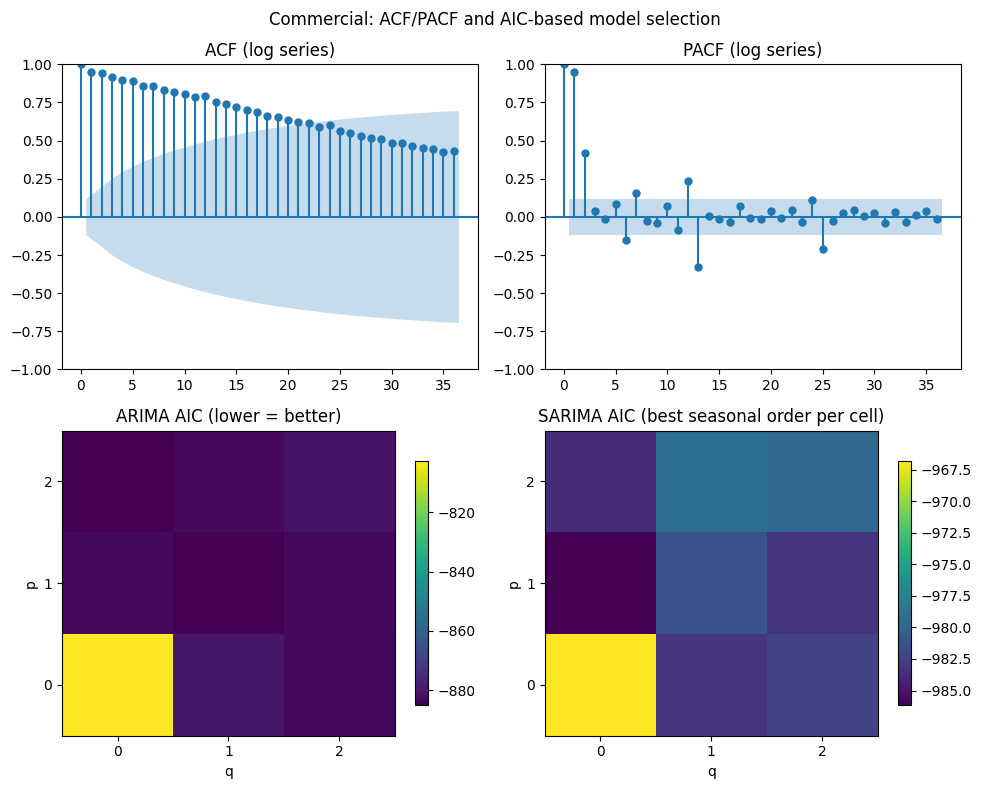

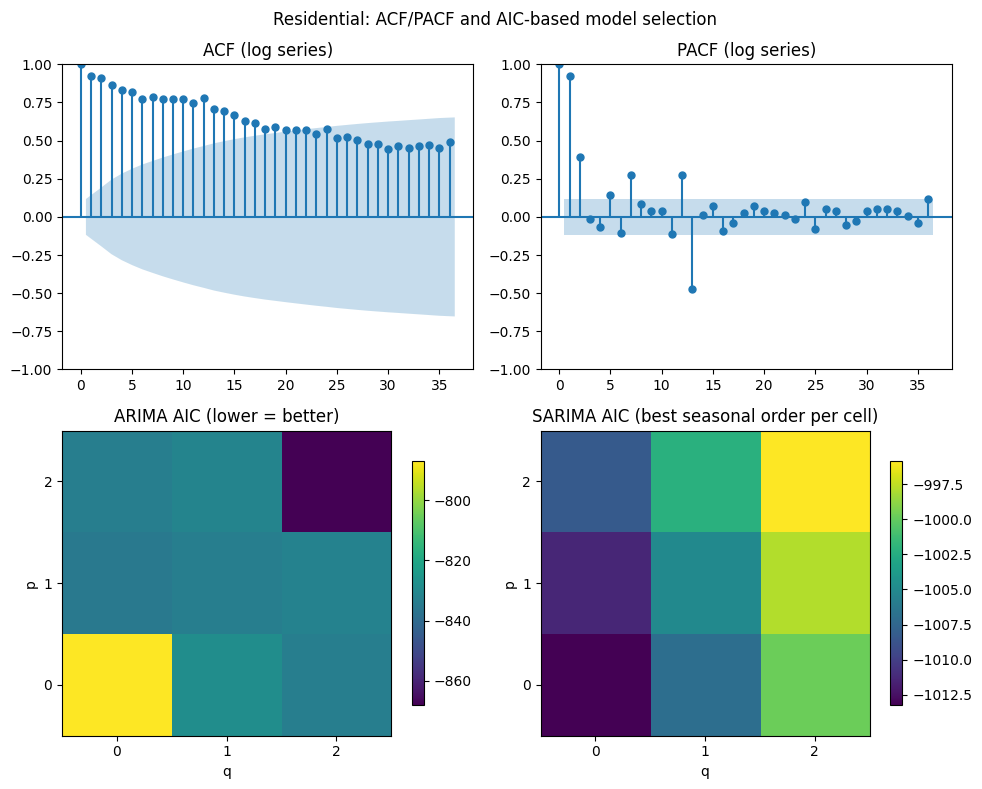

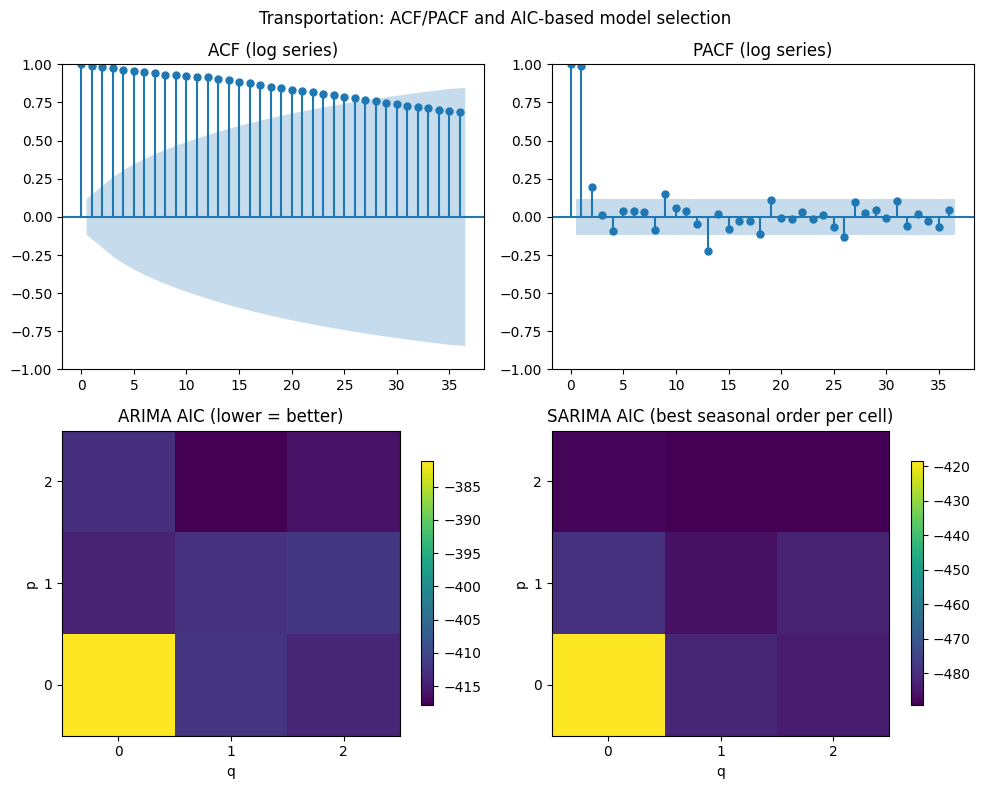

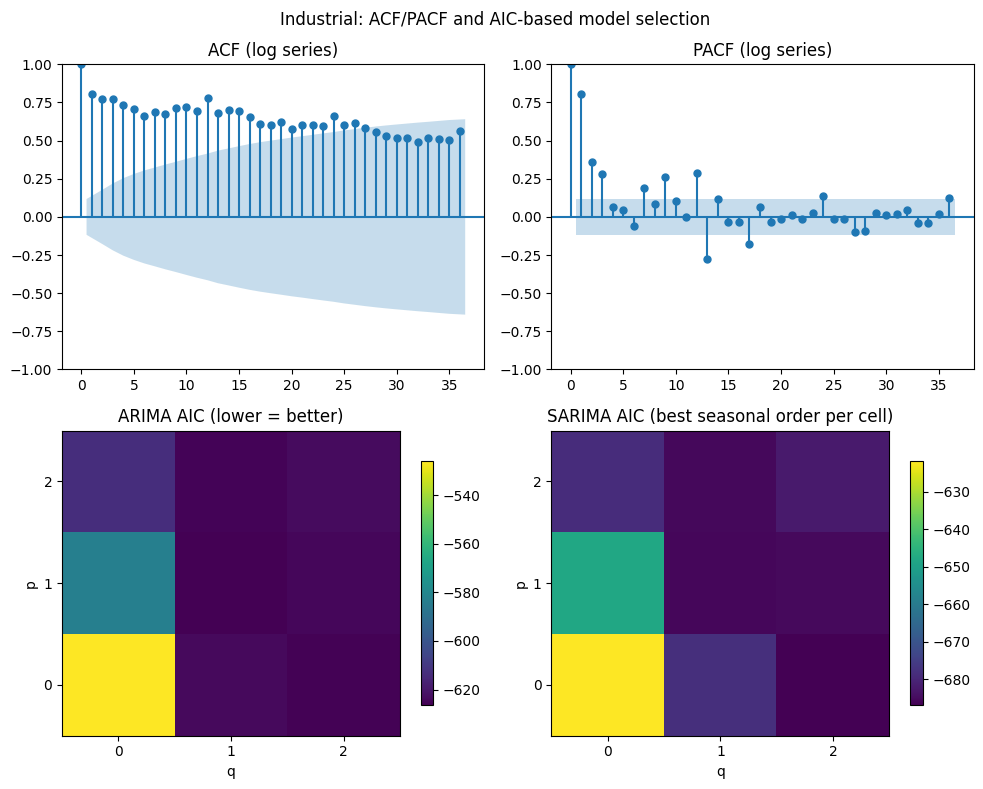

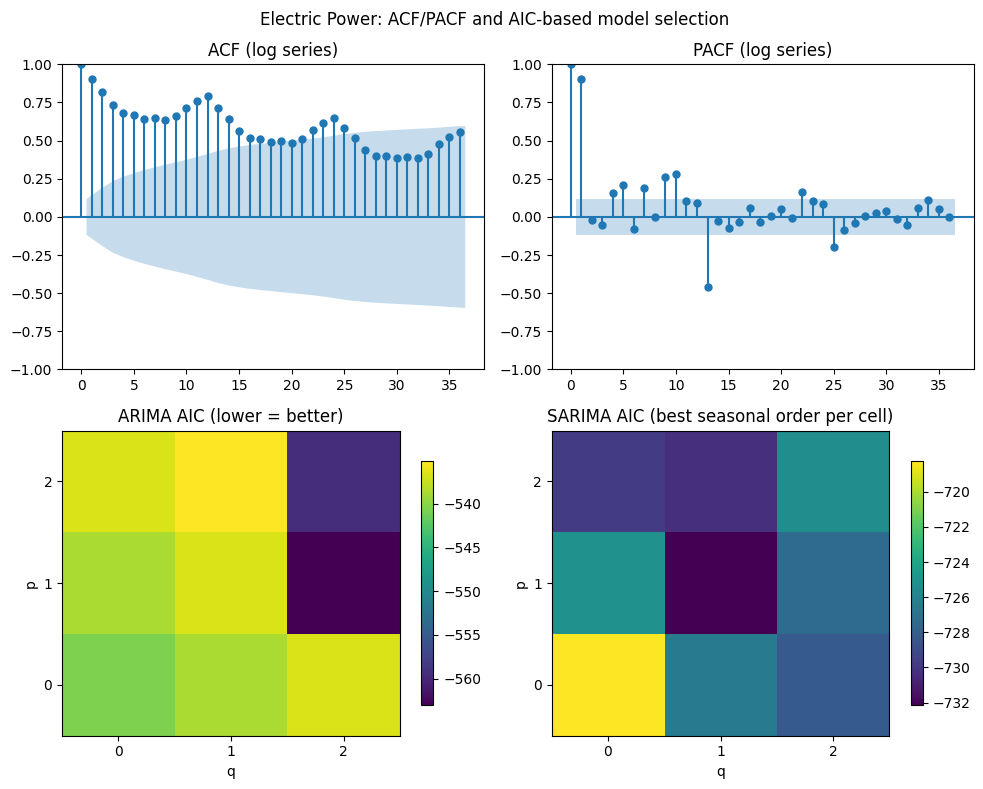

In [16]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from forecasting.preprocessing import maybe_log_transform

SECTORS = ["Commercial", "Residential", "Transportation", "Industrial", "Electric Power"]

# griglie piccole ma illustrative (puoi allargarle se il PC regge)
P_VALUES = [0, 1, 2]
D_VALUE  = 1
Q_VALUES = [0, 1, 2]

SP_VALUES = [0, 1]
SD_VALUE  = 1
SQ_VALUES = [0, 1]
S_PERIOD  = 12


def compute_arima_aic_grid(y_tr):
    """Restituisce una matrice AIC per (p,q) con d fisso."""
    aic_matrix = np.full((len(P_VALUES), len(Q_VALUES)), np.nan)
    for i, p in enumerate(P_VALUES):
        for j, q in enumerate(Q_VALUES):
            order = (p, D_VALUE, q)
            try:
                res = ARIMA(y_tr, order=order).fit()
                aic_matrix[i, j] = res.aic
            except Exception:
                # se il modello non converge, lasciamo NaN
                pass
    return aic_matrix


def compute_sarima_aic_grid(y_tr):
    """
    Restituisce una matrice AIC per (p,q) con (P,D,Q,12) già “ottimizzati”
    scegliendo, per ogni (p,q), la migliore combinazione stagionale in termini di AIC.
    """
    aic_matrix = np.full((len(P_VALUES), len(Q_VALUES)), np.nan)
    for i, p in enumerate(P_VALUES):
        for j, q in enumerate(Q_VALUES):
            best_aic = np.inf
            for P, D, Q in itertools.product(SP_VALUES, [SD_VALUE], SQ_VALUES):
                order = (p, D_VALUE, q)
                seasonal_order = (P, D, Q, S_PERIOD)
                try:
                    res = SARIMAX(
                        y_tr,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    ).fit(disp=False)
                    if res.aic < best_aic:
                        best_aic = res.aic
                except Exception:
                    pass
            if np.isfinite(best_aic):
                aic_matrix[i, j] = best_aic
    return aic_matrix


def plot_selection_diagnostics_for_sector(ts_log, sector_name, test_size_ratio=0.2, savefig=True):
    """
    Crea una figura 2x2 con:
      (1,1) ACF
      (1,2) PACF
      (2,1) heatmap AIC ARIMA
      (2,2) heatmap AIC SARIMA
    per la serie log-trasformata del settore specificato.
    """
    y_raw = ts[sector_name].dropna()
    y_log, logged = maybe_log_transform(y_raw)

    # usiamo solo il training (coerente con la scelta AIC)
    n = len(y_log)
    h = max(1, int(round(n * test_size_ratio)))
    y_tr = y_log.iloc[:-h]

    # calcola griglie AIC
    aic_arima = compute_arima_aic_grid(y_tr)
    aic_sarima = compute_sarima_aic_grid(y_tr)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f"{sector_name}: ACF/PACF and AIC-based model selection", fontsize=12)

    # 1) ACF
    plot_acf(y_tr, ax=axes[0, 0], lags=36)
    axes[0, 0].set_title("ACF (log series)")

    # 2) PACF
    plot_pacf(y_tr, ax=axes[0, 1], lags=36, method="ywm")
    axes[0, 1].set_title("PACF (log series)")

    # 3) Heatmap ARIMA AIC
    im1 = axes[1, 0].imshow(aic_arima,
                            origin="lower",
                            aspect="auto")
    axes[1, 0].set_xticks(range(len(Q_VALUES)), Q_VALUES)
    axes[1, 0].set_yticks(range(len(P_VALUES)), P_VALUES)
    axes[1, 0].set_xlabel("q")
    axes[1, 0].set_ylabel("p")
    axes[1, 0].set_title("ARIMA AIC (lower = better)")
    fig.colorbar(im1, ax=axes[1, 0], shrink=0.8)

    # 4) Heatmap SARIMA AIC
    im2 = axes[1, 1].imshow(aic_sarima,
                            origin="lower",
                            aspect="auto")
    axes[1, 1].set_xticks(range(len(Q_VALUES)), Q_VALUES)
    axes[1, 1].set_yticks(range(len(P_VALUES)), P_VALUES)
    axes[1, 1].set_xlabel("q")
    axes[1, 1].set_ylabel("p")
    axes[1, 1].set_title("SARIMA AIC (best seasonal order per cell)")
    fig.colorbar(im2, ax=axes[1, 1], shrink=0.8)

    plt.tight_layout()

    if savefig:
        from pathlib import Path
        out = Path("outputs/AIC_diagnostics")
        out.mkdir(exist_ok=True)
        fig.savefig(out / f"{sector_name}_arima_sarima_aic_diagnostics.png", dpi=300)

    return fig, axes


# Esegui per tutti i settori
for sector in SECTORS:
    plot_selection_diagnostics_for_sector(ts, sector)


## Diagnostics

In [17]:
combined = pd.concat([ts_vx, exog_vx], axis=1)

# Se vuoi una tabella completa:
corr_matrix = combined.corr()

corr_matrix

,Commercial,Electric Power,Industrial,Residential,Transportation,log_WTI,log_gas
Commercial,1.000000,0.936030,0.667133,0.708859,0.835339,0.346127,-0.298918
Electric Power,0.936030,1.000000,0.675220,0.666614,0.821849,0.365519,-0.324143
Industrial,0.667133,0.675220,1.000000,0.758767,0.844783,0.534485,-0.273750
Residential,0.708859,0.666614,0.758767,1.000000,0.842067,0.628016,-0.145334
Transportation,0.835339,0.821849,0.844783,0.842067,1.000000,0.675606,-0.188934
log_WTI,0.346127,0.365519,0.534485,0.628016,0.675606,1.000000,0.379601
log_gas,-0.298918,-0.324143,-0.273750,-0.145334,-0.188934,0.379601,1.000000


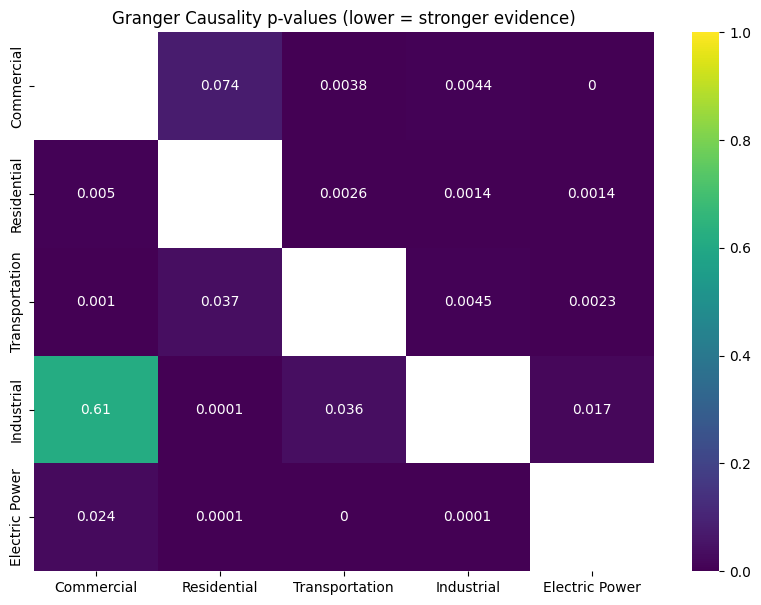

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carica la matrice dei p-values (oppure usa gc_pvalues direttamente)
gc_pvalues = pd.read_csv("outputs/granger_causality_pvalues.csv", index_col=0)

plt.figure(figsize=(10, 7))
sns.heatmap(gc_pvalues, annot=True, cmap="viridis", vmin=0, vmax=1)
plt.title("Granger Causality p-values (lower = stronger evidence)")
plt.show()

## SARIMA residual diagnostics

In [25]:
# SARIMA
import ast
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Carica il summary generato dallo script main.py
summary = pd.read_csv("outputs/forecast_summary.csv")

def get_sarima_spec(series_name: str):
    """
    Restituisce (order, seasonal_order) per una certa serie,
    leggendo la colonna Spec_SARIMA dal forecast_summary.csv.
    """
    row = summary.loc[summary["Series"] == series_name].iloc[0]
    spec_str = row["Spec_SARIMA"]  # es: "(0, 1, 1) x (1, 1, 1, 12)"
    
    # separa parte non stagionale e stagionale
    non_seasonal_str, seasonal_str = spec_str.split("x")
    order = ast.literal_eval(non_seasonal_str.strip())
    seasonal_order = ast.literal_eval(seasonal_str.strip())
    return order, seasonal_order

In [ ]:
sarima_residuals = {}   # dict: sector -> residual Series
sarima_models = {}      # opzionale, se vuoi conservare gli oggetti stimati

for col in VAR_SECTOR_COLS:
    y = ts_log[col].dropna()
    order, seasonal_order = get_sarima_spec(col)
    
    print(f"Fitting SARIMA{order}x{seasonal_order} for {col}...")
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res_sarima = model.fit(disp=False)
    
    sarima_models[col] = res_sarima
    sarima_residuals[col] = res_sarima.resid

print("Done. SARIMA residuals stored in sarima_residuals.")

Fitting SARIMA(0, 1, 1)x(1, 1, 1, 12) for Commercial...
Fitting SARIMA(0, 1, 1)x(0, 1, 1, 12) for Residential...
Fitting SARIMA(2, 1, 1)x(0, 1, 1, 12) for Transportation...


c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting SARIMA(1, 1, 1)x(0, 1, 1, 12) for Industrial...
Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) for Electric Power...
Done. SARIMA residuals stored in sarima_residuals.


In [ ]:
## SARIMA DIAGNOSTICS
# Reesiduals, squared residuals, Ljung box

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

def residual_diagnostics_univariate(resid, model_name="", lags=24):
    resid = resid.dropna()

    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    sm.graphics.tsa.plot_acf(resid, lags=lags, ax=axs[0])
    axs[0].set_title(f"ACF of Residuals – {model_name}")
    sm.graphics.tsa.plot_acf(resid**2, lags=lags, ax=axs[1])
    axs[1].set_title(f"ACF of Squared Residuals – {model_name}")
    plt.tight_layout()
    plt.show()

    lb_raw = acorr_ljungbox(resid, lags=[lags], return_df=True)
    lb_sq  = acorr_ljungbox(resid**2, lags=[lags], return_df=True)

    print(f"Ljung-Box Test (residuals) – {model_name}")
    print(lb_raw)
    print()
    print(f"Ljung-Box Test (squared residuals) – {model_name}")
    print(lb_sq)


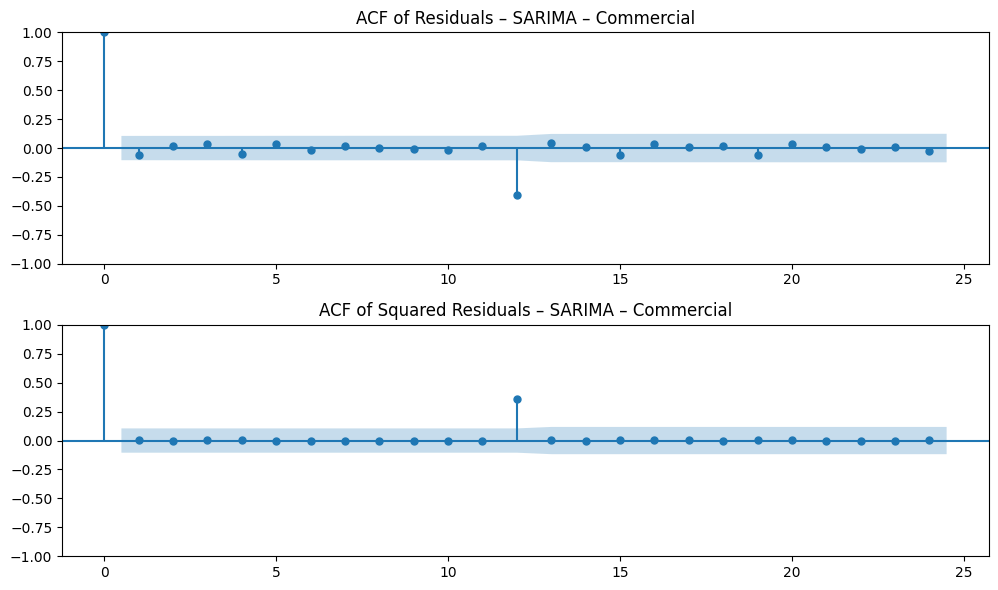

Ljung-Box Test (residuals) – SARIMA – Commercial
      lb_stat  lb_pvalue
24  69.314027   0.000003

Ljung-Box Test (squared residuals) – SARIMA – Commercial
      lb_stat  lb_pvalue
24  47.129705    0.00323


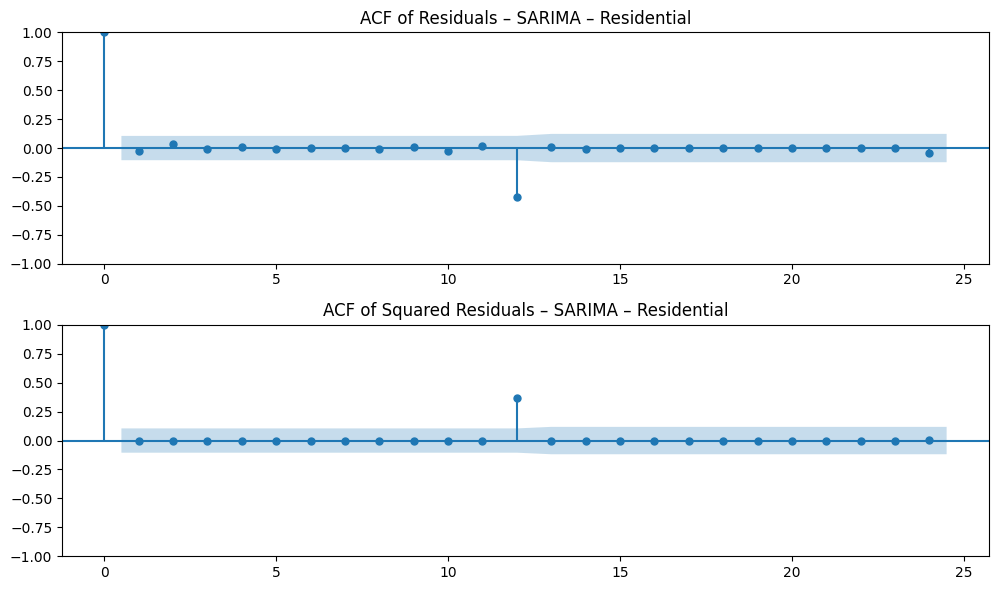

Ljung-Box Test (residuals) – SARIMA – Residential
      lb_stat  lb_pvalue
24  66.146179   0.000008

Ljung-Box Test (squared residuals) – SARIMA – Residential
      lb_stat  lb_pvalue
24  49.553708   0.001613


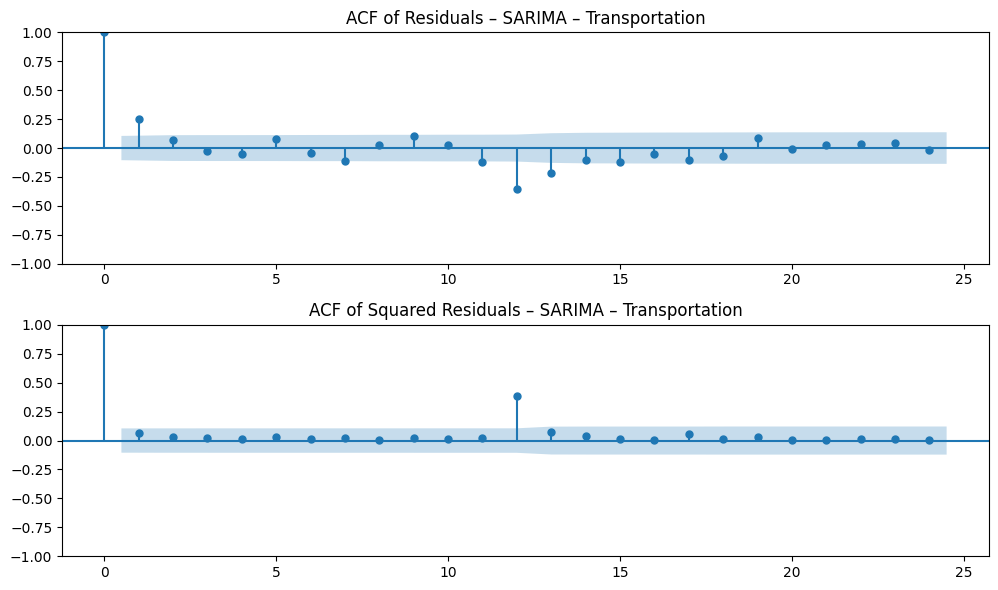

Ljung-Box Test (residuals) – SARIMA – Transportation
       lb_stat     lb_pvalue
24  125.331001  1.078938e-15

Ljung-Box Test (squared residuals) – SARIMA – Transportation
      lb_stat  lb_pvalue
24  61.933914   0.000034


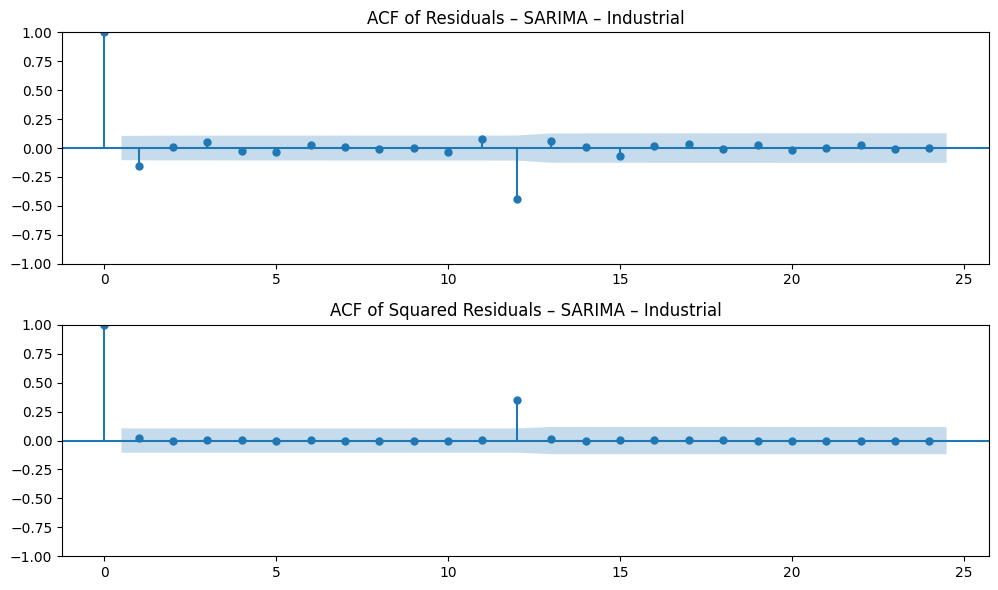

Ljung-Box Test (residuals) – SARIMA – Industrial
      lb_stat     lb_pvalue
24  87.182684  4.196746e-09

Ljung-Box Test (squared residuals) – SARIMA – Industrial
      lb_stat  lb_pvalue
24  45.420254   0.005193


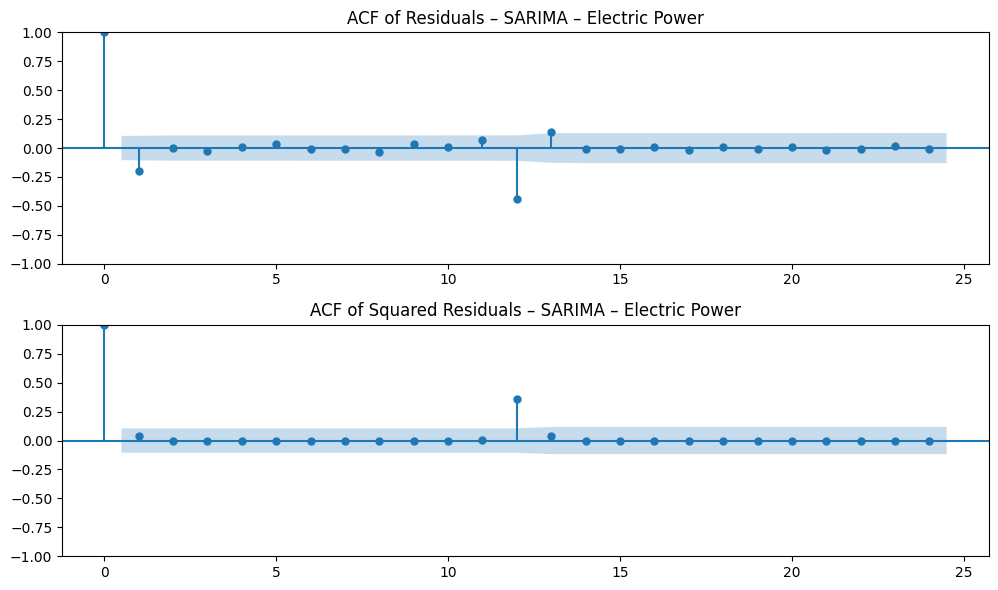

Ljung-Box Test (residuals) – SARIMA – Electric Power
      lb_stat     lb_pvalue
24  97.106477  9.316337e-11

Ljung-Box Test (squared residuals) – SARIMA – Electric Power
      lb_stat  lb_pvalue
24  47.603275   0.002825


In [28]:
for col in VAR_SECTOR_COLS:
    residual_diagnostics_univariate(
        sarima_residuals[col],
        model_name=f"SARIMA – {col}",
        lags=24
    )

## VAR residual diagnostics

In [19]:
from statsmodels.tsa.api import VAR

# === VAR stability check on log-transformed sector series ===

# 1) Use only the sector columns in log levels
sector_ts_log = ts_log[VAR_SECTOR_COLS].dropna()

# 2) Simple train-test split consistent with TEST_SIZE_RATIO
n_obs = len(sector_ts_log)
h = int(round(n_obs * TEST_SIZE_RATIO))
train_ts = sector_ts_log.iloc[:-h]
test_ts  = sector_ts_log.iloc[-h:]

print("Total observations:", n_obs)
print("Train size:", train_ts.shape[0])
print("Test size :", test_ts.shape[0])

# 3) Fit a VAR model and check stability
model = VAR(train_ts)

# Option A: let AIC choose p up to VAR_LAGS
res = model.fit(maxlags=VAR_LAGS, ic="aic")
print("Chosen lag order (AIC):", res.k_ar)

# Option B (if you want to force VAR_LAGS):
# res = model.fit(VAR_LAGS)
# print("Forced lag order:", VAR_LAGS)

print("Is the VAR stable?", res.is_stable())

# (optional) show eigenvalues of the companion matrix
import numpy as np
print("Eigenvalues (modulus):")
print(np.abs(res.roots))
print("All outside unit circle?", np.all(np.abs(res.roots) > 1))

res = model.fit(maxlags=2, ic="aic")
print(np.abs(res.roots))
print(np.all(np.abs(res.roots) > 1))


Total observations: 349
Train size: 279
Test size : 70
Chosen lag order (AIC): 4
Is the VAR stable? True
Eigenvalues (modulus):
[3.19970881 3.19970881 2.56902605 1.84883296 1.84883296 1.83555596
 1.83555596 1.79564215 1.77906262 1.77906262 1.72467852 1.72467852
 1.50818676 1.50818676 1.39570789 1.20638994 1.20638994 1.03854516
 1.01828483 1.0078427 ]
All outside unit circle? True
[4.87871214 3.19186643 3.19186643 1.90632357 1.85922555 1.49585707
 1.49585707 1.07468748 1.01752087 1.00586133]
True


In [ ]:
## VAR DIAGNOSTICS
# Reesiduals, squared residuals, Ljung box
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

def residual_diagnostics(resid, model_name="", lags=24):
    resid = resid.dropna()

    # === ACF residui normali ===
    fig, ax = plt.subplots(figsize=(8, 3))
    sm.graphics.tsa.plot_acf(resid, lags=lags, ax=ax)
    ax.set_title(f"ACF of Residuals - {model_name}")
    plt.tight_layout()
    plt.show()

    # === ACF residui al quadrato ===
    fig, ax = plt.subplots(figsize=(8, 3))
    sm.graphics.tsa.plot_acf(resid**2, lags=lags, ax=ax)
    ax.set_title(f"ACF of Squared Residuals - {model_name}")
    plt.tight_layout()
    plt.show()

    # === Ljung-Box test sui residui ===
    lb_raw = acorr_ljungbox(resid, lags=[lags], return_df=True)
    lb_sq  = acorr_ljungbox(resid**2, lags=[lags], return_df=True)

    print(f"Ljung-Box Test (residuals) for {model_name}")
    print(lb_raw)
    print()
    print(f"Ljung-Box Test (squared residuals) for {model_name}")
    print(lb_sq)

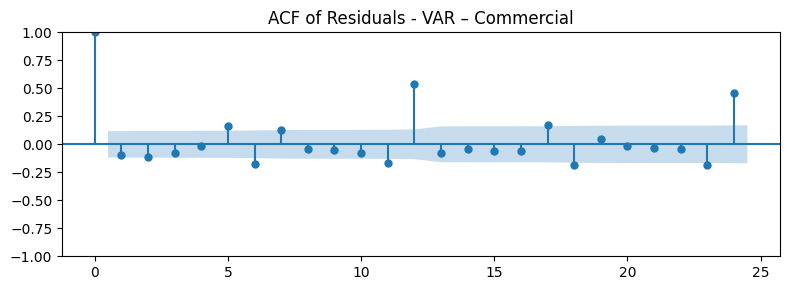

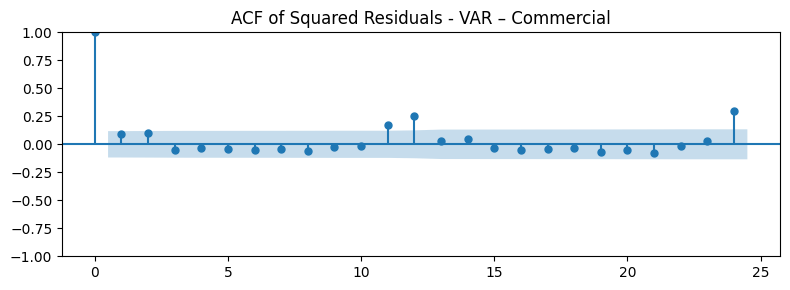

Ljung-Box Test (residuals) for VAR – Commercial
       lb_stat     lb_pvalue
24  223.188694  3.182044e-34

Ljung-Box Test (squared residuals) for VAR – Commercial
      lb_stat  lb_pvalue
24  70.487331   0.000002


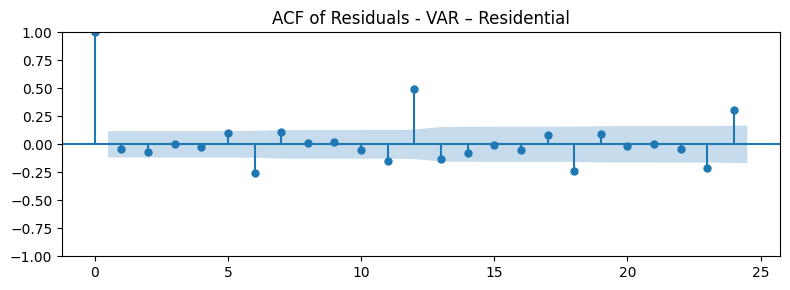

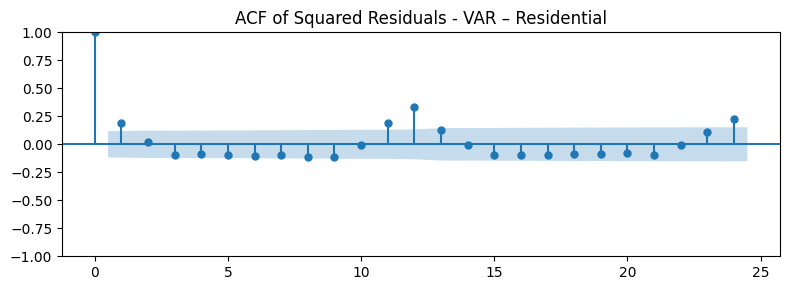

Ljung-Box Test (residuals) for VAR – Residential
       lb_stat     lb_pvalue
24  177.514895  2.182343e-25

Ljung-Box Test (squared residuals) for VAR – Residential
       lb_stat     lb_pvalue
24  114.517812  9.087011e-14


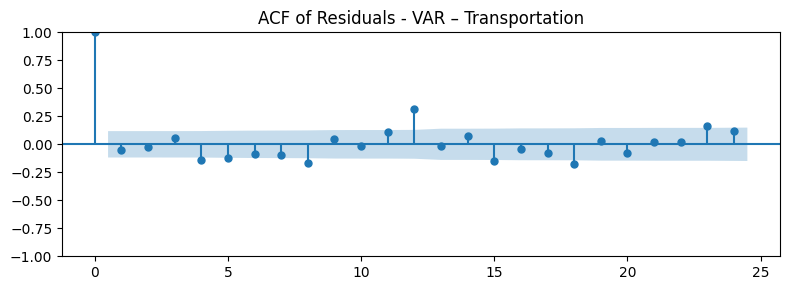

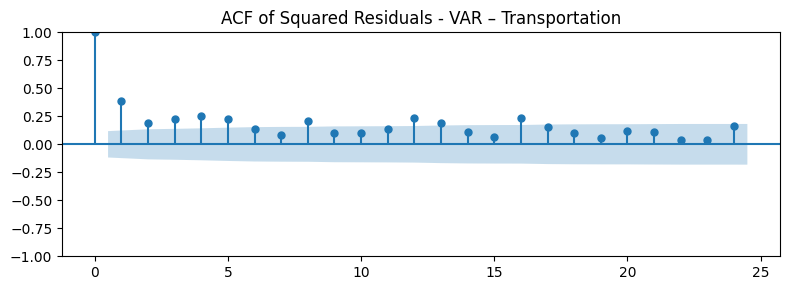

Ljung-Box Test (residuals) for VAR – Transportation
      lb_stat     lb_pvalue
24  92.759708  5.011595e-10

Ljung-Box Test (squared residuals) for VAR – Transportation
       lb_stat     lb_pvalue
24  206.621609  5.438526e-31


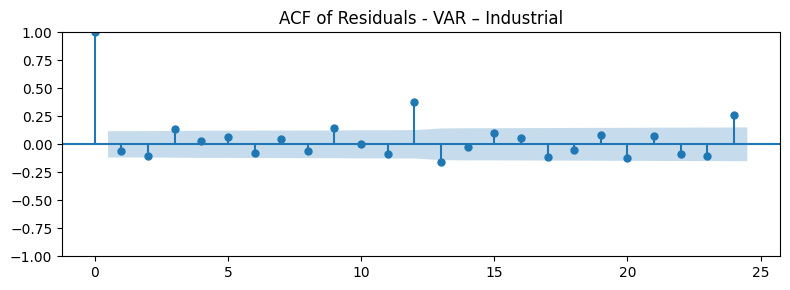

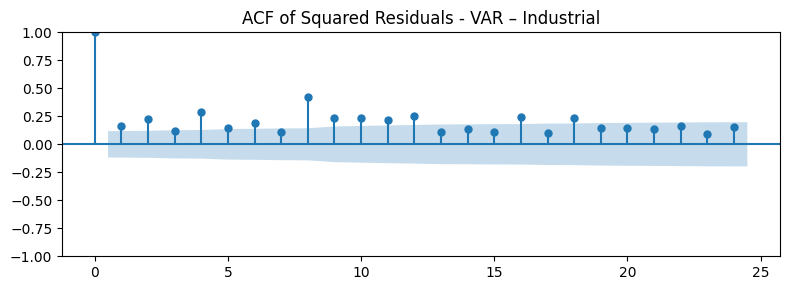

Ljung-Box Test (residuals) for VAR – Industrial
      lb_stat     lb_pvalue
24  114.03106  1.107104e-13

Ljung-Box Test (squared residuals) for VAR – Industrial
       lb_stat     lb_pvalue
24  269.067538  2.663504e-43


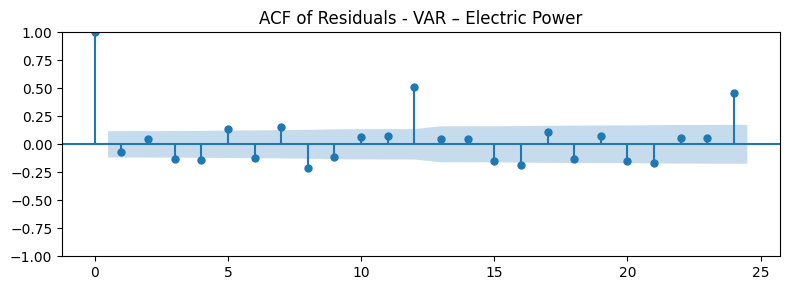

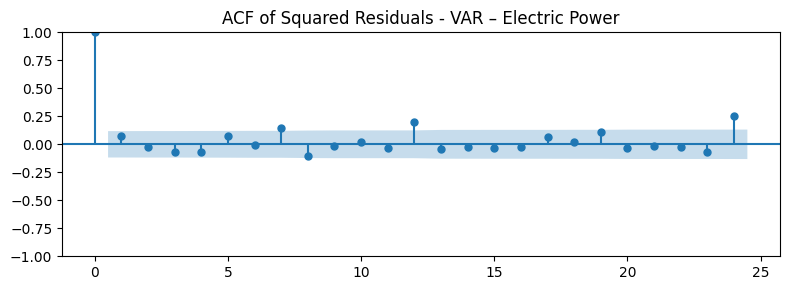

Ljung-Box Test (residuals) for VAR – Electric Power
       lb_stat     lb_pvalue
24  235.492927  1.215669e-36

Ljung-Box Test (squared residuals) for VAR – Electric Power
      lb_stat  lb_pvalue
24  55.365511   0.000279


In [24]:
residuals = res.resid
for col in residuals.columns:
    residual_diagnostics(residuals[col], model_name=f"VAR – {col}", lags=24)

## VARX residuals diagnostics

In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.varmax import VARMAX

# log-series settoriali (dovresti averlo già)
ts_log = np.log(ts)   # o come l'hai chiamato tu
sector_ts_log = ts_log[VAR_SECTOR_COLS].dropna()

# macro variabili in log (già usate per il VARX)
macro = pd.read_csv(MACRO_PATH, parse_dates=["date"])
macro.set_index("date", inplace=True)

macro_log = pd.DataFrame({
    "log_WTI": np.log(macro["WTI"]),
    "log_gas": np.log(macro["gas"])
})

# allinea settori e exog
exog = macro_log[["log_WTI", "log_gas"]]
mask = sector_ts_log.notna().all(axis=1) & exog.notna().all(axis=1)

ts_vx   = sector_ts_log.loc[mask]
exog_vx = exog.loc[mask]

In [32]:
n_obs = len(ts_vx)
h = int(round(n_obs * TEST_SIZE_RATIO))

endog_train = ts_vx.iloc[:-h]
endog_test  = ts_vx.iloc[-h:]

exog_train  = exog_vx.iloc[:-h]
exog_test   = exog_vx.iloc[-h:]

In [34]:
# prendi l'ordine dal VAR già stimato
p = res.k_ar        # res è il fit del VAR che hai già stimato

print("Using VAR lag order for VARX:", p)

varx_mod = VARMAX(endog_train, exog=exog_train, order=(p, 0), enforce_stationarity=False)
res_varx = varx_mod.fit(maxiter=1000, disp=False)

print(res_varx.summary())

# residui del VARX (train)
residuals_varx = res_varx.resid
print("VARX residuals shape:", residuals_varx.shape)
print("Columns:", residuals_varx.columns.tolist())

Using VAR lag order for VARX: 2


c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                          Statespace Model Results                                                         
Dep. Variable:     ['Commercial', 'Residential', 'Transportation', 'Industrial', 'Electric Power']   No. Observations:                  260
Model:                                                                                     VARX(2)   Log Likelihood                1830.746
                                                                                       + intercept   AIC                          -3501.492
Date:                                                                             Fri, 05 Dec 2025   BIC                          -3216.637
Time:                                                                                     10:08:45   HQIC                         -3386.977
Sample:                                                                                 01-01-1997                                         
                    

In [35]:
residuals_varx = res_varx.resid
print(residuals_varx.shape)
print(residuals_varx.columns)

(260, 5)
Index(['Commercial', 'Residential', 'Transportation', 'Industrial',
       'Electric Power'],
      dtype='object')


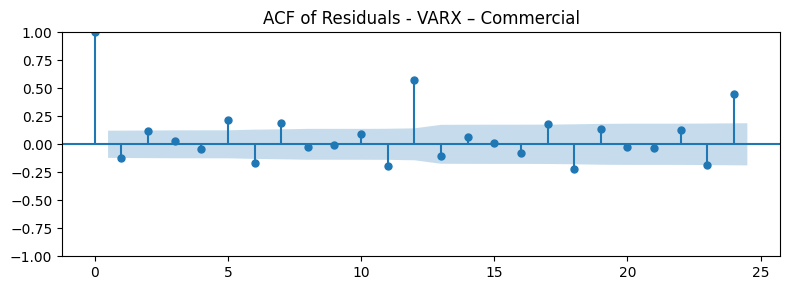

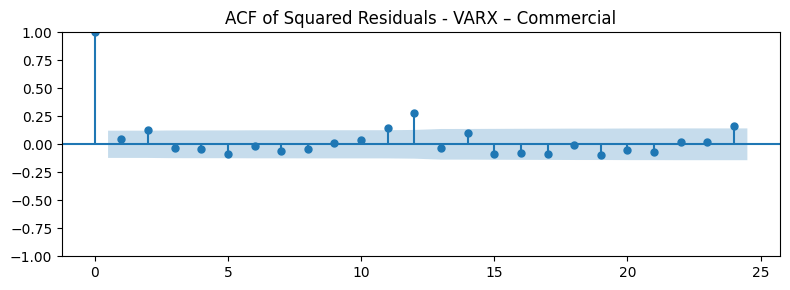

Ljung-Box Test (residuals) for VARX – Commercial
       lb_stat     lb_pvalue
24  251.368058  8.840278e-40

Ljung-Box Test (squared residuals) for VARX – Commercial
      lb_stat  lb_pvalue
24  57.972646   0.000123


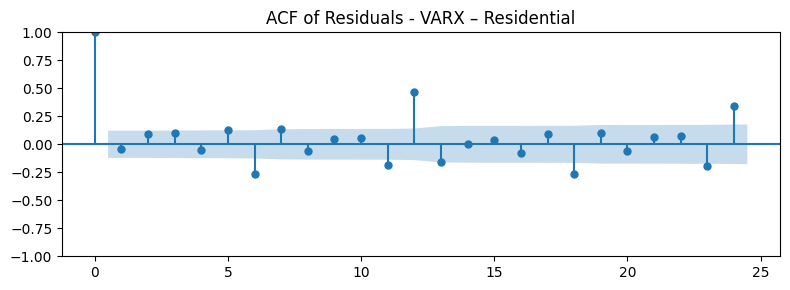

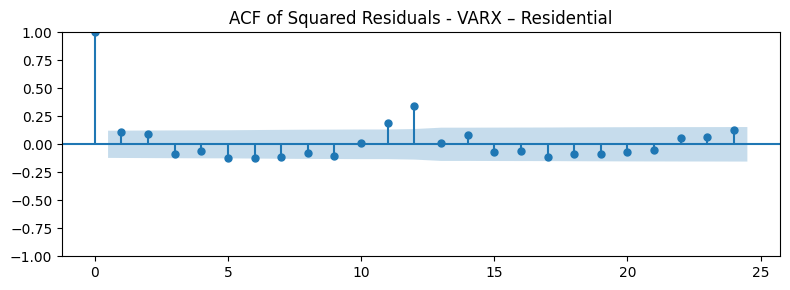

Ljung-Box Test (residuals) for VARX – Residential
       lb_stat     lb_pvalue
24  189.561123  1.078934e-27

Ljung-Box Test (squared residuals) for VARX – Residential
      lb_stat     lb_pvalue
24  88.327505  2.721955e-09


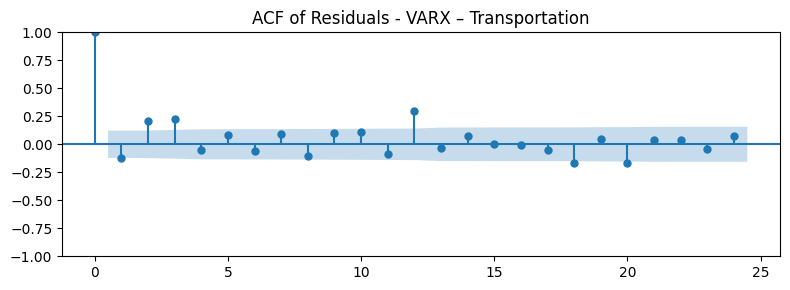

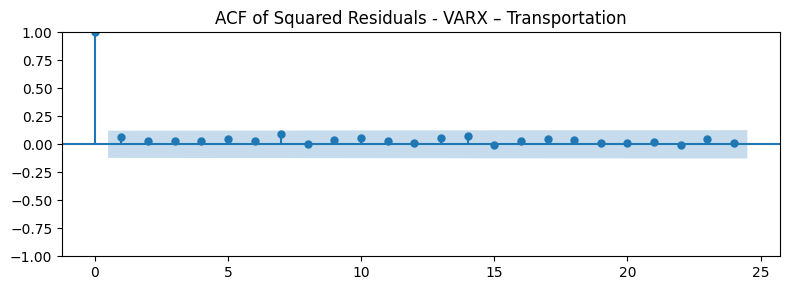

Ljung-Box Test (residuals) for VARX – Transportation
      lb_stat     lb_pvalue
24  91.822886  7.181242e-10

Ljung-Box Test (squared residuals) for VARX – Transportation
      lb_stat  lb_pvalue
24  11.623734   0.983824


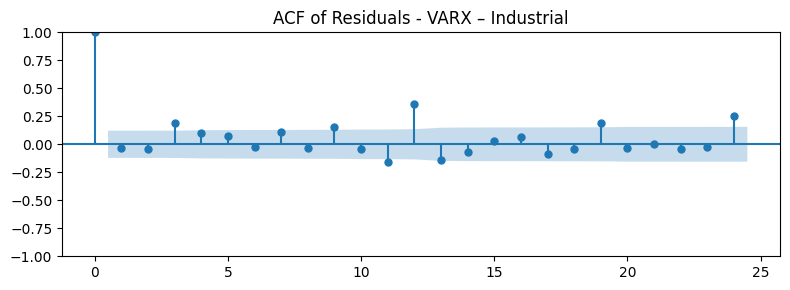

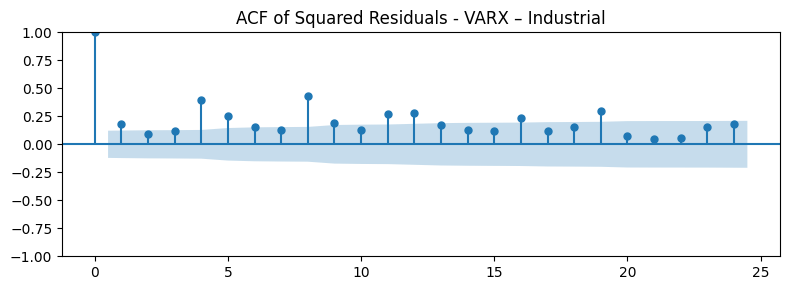

Ljung-Box Test (residuals) for VARX – Industrial
       lb_stat     lb_pvalue
24  105.625982  3.246810e-12

Ljung-Box Test (squared residuals) for VARX – Industrial
       lb_stat     lb_pvalue
24  279.044667  2.701013e-45


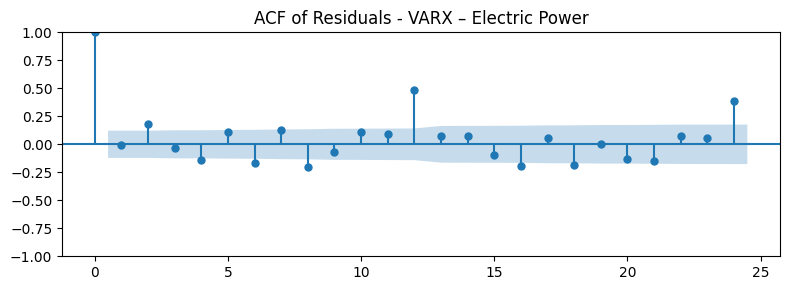

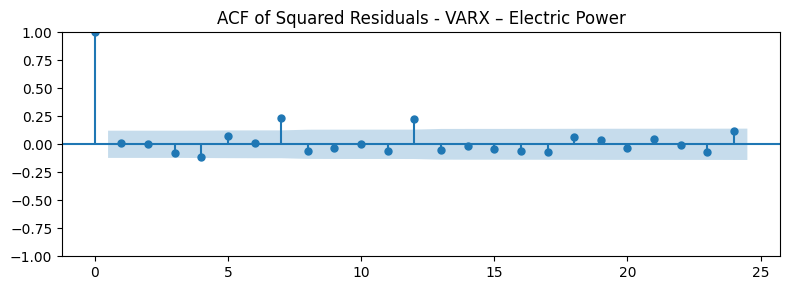

Ljung-Box Test (residuals) for VARX – Electric Power
       lb_stat     lb_pvalue
24  195.686438  7.130005e-29

Ljung-Box Test (squared residuals) for VARX – Electric Power
      lb_stat  lb_pvalue
24  48.759461    0.00203


In [36]:
for col in residuals_varx.columns:
    residual_diagnostics(
        residuals_varx[col],
        model_name=f"VARX – {col}",
        lags=24
    )

## GARCH (1,1)

In [40]:
!c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Scripts\python.exe -m pip install arch

  Using cached arch-8.0.0-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached arch-8.0.0-cp312-cp312-win_amd64.whl (930 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
from arch import arch_model

def fit_garch_on_residuals(resid, label="", p=1, q=1):
    """
    Fit di un modello GARCH(p,q) su una serie di residui (mean già modellata).
    Usa mean='Zero' perché la dinamica della media è già catturata da SARIMA/VAR/VARX.
    """
    resid = resid.dropna()

    am = arch_model(resid, vol="GARCH", p=p, q=q, mean="Zero")
    res_garch = am.fit(disp="off")

    print(f"\n=== {label} ===")
    print(res_garch.summary())
    
    # Controllo rapido della persistenza (alpha+beta < 1)
    params = res_garch.params
    alpha = params.filter(regex=r"alpha").sum()
    beta  = params.filter(regex=r"beta").sum()
    print(f"alpha+beta = {alpha + beta:.3f}")

    return res_garch

### GARCH on SARIMA

In [42]:
garch_sarima = {}

for col in VAR_SECTOR_COLS:
    res_garch = fit_garch_on_residuals(
        sarima_residuals[col],
        label=f"SARIMA–GARCH – {col}",
        p=1, q=1
    )
    garch_sarima[col] = res_garch


=== SARIMA–GARCH – Commercial ===
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:                562.956
Distribution:                  Normal   AIC:                          -1119.91
Method:            Maximum Likelihood   BIC:                          -1108.35
                                        No. Observations:                  349
Date:                Fri, Dec 05 2025   Df Residuals:                      349
Time:                        10:24:40   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.5416e-0

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_sca

### GARCH on VAR

In [43]:
residuals_var = res.resid   # DataFrame con le 5 colonne dei settori

garch_var = {}

for col in residuals_var.columns:
    res_garch = fit_garch_on_residuals(
        residuals_var[col],
        label=f"VAR–GARCH – {col}",
        p=1, q=1
    )
    garch_var[col] = res_garch


=== VAR–GARCH – Commercial ===
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Commercial   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:                462.093
Distribution:                  Normal   AIC:                          -918.186
Method:            Maximum Likelihood   BIC:                          -907.314
                                        No. Observations:                  277
Date:                Fri, Dec 05 2025   Df Residuals:                      277
Time:                        10:26:34   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2153e-05  

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002108. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002331. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_

### GARCH on VARX

In [44]:
residuals_varx = res_varx.resid   # già usato per la diagnostica

garch_varx = {}

for col in residuals_varx.columns:
    res_garch = fit_garch_on_residuals(
        residuals_varx[col],
        label=f"VARX–GARCH – {col}",
        p=1, q=1
    )
    garch_varx[col] = res_garch



=== VARX–GARCH – Commercial ===
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Commercial   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:                423.585
Distribution:                  Normal   AIC:                          -841.171
Method:            Maximum Likelihood   BIC:                          -830.489
                                        No. Observations:                  260
Date:                Fri, Dec 05 2025   Df Residuals:                      260
Time:                        10:26:48   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4091e-03  3.

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_